In [1]:
# setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import typing
import sklearn
import nltk

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /home/pw98/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/pw98/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

links:
   -  https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv 
   -  (http://www.clungu.com/Visualising-grid-search-results/)

# Read Data

In [2]:
from src.data_processing.preprocess import load_arff_data


def load_traffic():
    data = pd.read_csv('data/raw/traffic-data/Traffic.csv')
     # Convert 'Time' to hour (if necessary)
    if 'Time' in data:
        data['Time'] = pd.to_datetime(
            data['Time'], format='%I:%M:%S %p', errors='coerce').dt.hour
        data['Time'].fillna(data['Time'].mode()[0], inplace=True)

    # Process 'Date' column to retain only the day of the month
    if 'Date' in data:
        data['Day'] = pd.to_numeric(data['Date'], errors='coerce')

    # Ensure 'Day of the week' is correctly formatted as categorical
    if 'Day of the week' in data:
        data['Day of the week'] = data['Day of the week'].astype(str)

    # Check for missing values in 'Traffic Situation' column
    if 'Traffic Situation' not in data:
        raise ValueError(
            "'Traffic Situation' column is missing from the traffic dataset.")

    return data

def load_amazon():
    data = pd.read_csv(
        'data/raw/amazon-reviews/amazon_review_ID.shuf.lrn.csv')
    data = data.drop(columns=['ID'])
    return data

def load_wine():
    file_path = 'data/raw/wine-reviews.arff'
    columns = ['country', 'description', 'designation', 'points', 'price', 'province',
                'region_1', 'region_2', 'variety', 'winery']

    # Load raw data and drop unnecessary columns
    wine_df = load_arff_data(
        file_path,
        columns,
        drop_columns=['designation', 'points', 'price', 'province', 'region_1',
                        'region_2', 'variety', 'winery']
    )
    return wine_df

def load_votings():
    data = pd.read_csv('data/raw/congressional-voting/CongressionalVotingID.shuf.lrn.csv')
    return data

In [3]:
traffic_read_df = load_traffic()
amazon_read_df = load_amazon()
wine_read_df = load_wine()
votings_read_df = load_votings()
raw_data = {
    'Traffic': traffic_read_df,
    'Amazon': amazon_read_df,
    'Wine': wine_read_df,
    'Votings': votings_read_df,
}
raw_data

/tmp/ipykernel_563616/2108428438.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Time'].fillna(data['Time'].mode()[0], inplace=True)


file_path: data/raw/wine-reviews.arff exists
Data lines start from line index 15.
Parsed 150930 rows successfully.
Sample of the parsed DataFrame:
  country                                        description  \
0      US  This tremendous 100\% varietal wine hails from...   
1   Spain  Ripe aromas of fig, blackberry and cassis are ...   
2      US  Mac Watson honors the memory of a wine once ma...   
3      US  This spent 20 months in 30\% new French oak, a...   
4  France  This is the top wine from La Bégude, named aft...   

                            designation points  price        province  \
0                    Martha\'s Vineyard     96  235.0      California   
1  Carodorum Selección Especial Reserva     96  110.0  Northern Spain   
2         Special Selected Late Harvest     96   90.0      California   
3                               Reserve     96   65.0          Oregon   
4                            La Brûlade     95   66.0        Provence   

            region_1         

{'Traffic':       Time  Date Day of the week  CarCount  BikeCount  BusCount  TruckCount  \
 0        0    10         Tuesday        31          0         4           4   
 1        0    10         Tuesday        49          0         3           3   
 2        0    10         Tuesday        46          0         3           6   
 3        0    10         Tuesday        51          0         2           5   
 4        1    10         Tuesday        57          6        15          16   
 ...    ...   ...             ...       ...        ...       ...         ...   
 2971    22     9        Thursday        16          3         1          36   
 2972    23     9        Thursday        11          0         1          30   
 2973    23     9        Thursday        15          4         1          25   
 2974    23     9        Thursday        16          5         0          27   
 2975    23     9        Thursday        14          3         1          15   
 
       Total Traffic Situat

In [4]:
from sklearn.impute import SimpleImputer
from scipy.sparse import issparse
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from src.data_processing.preprocess import preprocess_text

def preprocess_traffic(raw_data: pd.DataFrame):
    preprocessed = raw_data.copy()
    X = preprocessed.drop(columns=['Traffic Situation', 'Date'])
    y = preprocessed['Traffic Situation']
    categorical_features = ['Day of the week']
    X = X.fillna(X.mode().iloc[0])
    X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
    return pd.concat([X, y], axis=1)


def preprocess_amazon(raw_data: pd.DataFrame):
    preprocessed = raw_data.copy()

    return preprocessed


def preprocess_wine(raw_data: pd.DataFrame):
    preprocessed = raw_data.copy()
    # Drop rows with missing 'country' or 'description'
    preprocessed.dropna(subset=['country', 'description'], inplace=True)
    
    # Preprocess text data
    print("Preprocessing text data...")
    preprocessed['description'] = preprocessed['description'].str.lower()
    preprocessed['description'] = [word_tokenize(text) for text in tqdm(
        preprocessed['description'], desc="Tokenizing")]
    preprocessed['description'] = [
        preprocess_text(tokens) for tokens in tqdm(preprocessed['description'], desc="Cleaning and lemmatizing")
    ]
    # Filter out classes with fewer than 2 instances
    country_counts = preprocessed['country'].value_counts()
    common_countries = country_counts[country_counts > 1].index
    preprocessed = preprocessed[preprocessed['country'].isin(common_countries)]
    
    global tfidf_vect
    tfidf_vect = TfidfVectorizer()

    X_tfidf = tfidf_vect.fit_transform(preprocessed['description'])
    y = preprocessed['country']
    X_df = pd.DataFrame.sparse.from_spmatrix(X_tfidf)
    if issparse(X_df):
        X_df = X_df.tocsr()
    print(X_df.isnull().sum())
    preprocessed = pd.concat([X_df.reset_index(drop=True), y.reset_index(drop=True)], axis=1, ignore_index=True,)
    print(preprocessed.isnull().sum())

    # d = dict.fromkeys(preprocessed.select_dtypes(np.int32).columns, np.int64)
    # preprocessed = preprocessed.astype(d)
    # print(preprocessed.info())
    return preprocessed


def preprocess_votings(raw_data: pd.DataFrame):
    preprocessed = raw_data.copy()
    X = preprocessed.drop(columns=['ID', 'class']).replace(
        {'y': 1, 'n': 0, 'unknown': np.nan})
    y = preprocessed['class']

    # Impute missing values
    imputer = SimpleImputer(strategy='most_frequent')
    X_imputed = imputer.fit_transform(X)

    # Convert back to DataFrame with original columns
    X_imputed = pd.DataFrame(X_imputed, columns=X.columns)
    return pd.concat([X_imputed, y], axis=1)

In [ ]:
wine_pp_df = preprocess_wine(raw_data['Wine'])

Preprocessing text data...


Cleaning and lemmatizing: 100%|██████████| 150925/150925 [06:45<00:00, 371.93it/s]


0        False
1        False
2        False
3        False
4        False
         ...  
37230    False
37231    False
37232    False
37233    False
37234    False
Length: 37235, dtype: Sparse[bool, False]


/tmp/ipykernel_563616/2252429013.py:55: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  print(preprocessed.isnull().sum())


0        False
1        False
2        False
3        False
4        False
         ...  
37231    False
37232    False
37233    False
37234    False
37235        0
Length: 37236, dtype: Sparse[int64, False]


In [28]:
wine_pp_df['country'] = wine_pp_df.iloc[:,37235]
wine_pp_df = wine_pp_df.drop(columns=[37235])
wine_pp_df

,0,1,2,3,4,5,6,7,8,9,...,37226,37227,37228,37229,37230,37231,37232,37233,37234,country
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,US
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Spain
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,US
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,US
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,France
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150919,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Italy
150920,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,France
150921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Italy
150922,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,France


In [26]:
display(wine_pp_df)

,0,1,2,3,4,5,6,7,8,9,...,37226,37227,37228,37229,37230,37231,37232,37233,37234,37235
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,US
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Spain
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,US
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,US
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,France
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150919,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Italy
150920,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,France
150921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Italy
150922,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,France


In [29]:
traffic_pp_df = preprocess_traffic(raw_data['Traffic'])
amazon_pp_df = preprocess_amazon(raw_data['Amazon'])

votings_pp_df = preprocess_votings(raw_data['Votings'])

preproccessed_data = {
    'Traffic': traffic_pp_df,
    'Amazon': amazon_pp_df,
    'Wine': wine_pp_df,
    'Votings': votings_pp_df,
}

/tmp/ipykernel_563616/2252429013.py:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = preprocessed.drop(columns=['ID', 'class']).replace(


In [ ]:
# todo pw: think about simpleImputer / handling of missing values

In [30]:
from sklearn.calibration import LabelEncoder


def label_encode(df_name: str, df: pd.DataFrame, target_column: str):
    if target_column not in df:
        raise ValueError(
            f"The {target_column} column is missing from the {df_name} dataset.")
    
    y = df[target_column]
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    return y_encoded, label_encoder

In [31]:
traffic_label_encoded = preproccessed_data['Traffic'].copy()
amazon_label_encoded = preproccessed_data['Amazon'].copy()
wine_label_encoded = preproccessed_data['Wine'].copy()
votings_label_encoded = preproccessed_data['Votings'].copy()

traffic_target_column = 'Traffic Situation'
traffic_label_encoded[traffic_target_column], traffic_encoder = label_encode('Traffic', traffic_label_encoded, traffic_target_column)

amazon_target_column = 'Class'
amazon_label_encoded[amazon_target_column], amazon_encoder = label_encode('Amazon', amazon_label_encoded, amazon_target_column)

wine_target_column = 'country'
wine_label_encoded[wine_target_column], wine_encoder = label_encode('Wine', wine_label_encoded, wine_target_column)

votings_target_column = 'class'
votings_label_encoded[votings_target_column], votings_encoder = label_encode('Votings', votings_label_encoded, votings_target_column)

target_classes = {
    'Traffic': traffic_target_column,
    'Amazon': amazon_target_column,
    'Wine': wine_target_column,
    'Votings': votings_target_column,
}

label_encoded_data = {
    'Traffic': traffic_label_encoded,
    'Amazon': amazon_label_encoded,
    'Wine': wine_label_encoded,
    'Votings': votings_label_encoded,
}
label_encoder = {
    'Traffic': traffic_encoder,
    'Amazon': amazon_encoder,
    'Wine': wine_encoder,
    'Votings': votings_encoder,
}
label_encoder

{'Traffic': LabelEncoder(),
 'Amazon': LabelEncoder(),
 'Wine': LabelEncoder(),
 'Votings': LabelEncoder()}

# 1. Create Train, validation and test split

In [32]:
from sklearn.model_selection import train_test_split

def split_data_train_test(df: pd.DataFrame, test_size: float=0.2,target_column: str = 'class') -> typing.Tuple[pd.DataFrame, pd.DataFrame]:

    # separate features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=42,
        stratify=y
    )
    
    # reconstruct DataFrames
    df_train = pd.concat([X_train, y_train], axis=1)
    df_test = pd.concat([X_test, y_test], axis=1)
    
    return df_train, df_test


In [33]:
class TrainTestSplittedData:
    train: pd.DataFrame
    test: pd.DataFrame


test_size = 0.2

traffic_splitted_data = TrainTestSplittedData()
traffic_splitted_data.train, traffic_splitted_data.test = split_data_train_test(
    label_encoded_data['Traffic'], test_size, traffic_target_column
)

amazon_splitted_data = TrainTestSplittedData()
amazon_splitted_data.train, amazon_splitted_data.test = split_data_train_test(
    label_encoded_data['Amazon'], test_size, amazon_target_column
)

wine_splitted_data = TrainTestSplittedData()
wine_splitted_data.train, wine_splitted_data.test = split_data_train_test(
    label_encoded_data['Wine'], test_size, wine_target_column
)

votings_splitted_data = TrainTestSplittedData()
votings_splitted_data.train, votings_splitted_data.test = split_data_train_test(
    label_encoded_data['Votings'], test_size, votings_target_column
)
train_test_data = {
    'Traffic': traffic_splitted_data,
    'Amazon': amazon_splitted_data,
    'Wine': wine_splitted_data,
    'Votings': votings_splitted_data,
}
train_data = {
    'Traffic': traffic_splitted_data.train,
    'Amazon': amazon_splitted_data.train,
    'Wine': wine_splitted_data.train,
    'Votings': votings_splitted_data.train,
}

test_data = {
    'Traffic': traffic_splitted_data.test,
    'Amazon': amazon_splitted_data.test,
    'Wine': wine_splitted_data.test,
    'Votings': votings_splitted_data.test,
}

In [34]:
def split_data_train_valid(df:pd.DataFrame, valid_size:float, target_class:str) -> typing.Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    # separate features and target
    X = df.drop(columns=[target_class])
    y = df[target_class]
    
    # split the data
    X_train, X_valid, y_train, y_valid = train_test_split(
        X,
        y,
        test_size=valid_size,
        random_state=42,
        stratify=y
    )
    return X_train, y_train, X_valid, y_valid

In [35]:
class TrainValidSplittedData:
    X_train: pd.DataFrame
    y_train: pd.Series
    X_valid: pd.DataFrame
    y_valid: pd.Series


valid_size = 0.1

traffic_tv_splitted_data = TrainValidSplittedData()
traffic_tv_splitted_data.X_train, traffic_tv_splitted_data.y_train, traffic_tv_splitted_data.X_valid, traffic_tv_splitted_data.y_valid = split_data_train_valid(
    train_data['Traffic'], valid_size, traffic_target_column
)

amazon_tv_splitted_data = TrainValidSplittedData()
amazon_tv_splitted_data.X_train, amazon_tv_splitted_data.y_train, amazon_tv_splitted_data.X_valid, amazon_tv_splitted_data.y_valid = split_data_train_valid(
    train_data['Amazon'], valid_size, amazon_target_column
)

wine_tv_splitted_data = TrainValidSplittedData()
wine_tv_splitted_data.X_train, wine_tv_splitted_data.y_train, wine_tv_splitted_data.X_valid, wine_tv_splitted_data.y_valid = split_data_train_valid(
    train_data['Wine'], valid_size, wine_target_column
)

votings_tv_splitted_data = TrainValidSplittedData()
votings_tv_splitted_data.X_train, votings_tv_splitted_data.y_train, votings_tv_splitted_data.X_valid, votings_tv_splitted_data.y_valid = split_data_train_valid(
    train_data['Votings'], valid_size, votings_target_column
)

train_valid_data = {
    'Traffic': traffic_tv_splitted_data,
    'Amazon': amazon_tv_splitted_data,
    'Wine': wine_tv_splitted_data,
    'Votings': votings_tv_splitted_data,
}

# 2. First ML experiments

In [36]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
suitable_ml_methods = [
    LinearSVC,
    RandomForestClassifier,
    KNeighborsClassifier
]
def print_selection(selected: list, sel_type:str='methods'):
    print(f"Identified {sel_type}:\n===================\n"+ 
            '\n'.join([cur_sel.__name__ for cur_sel in selected]))
print_selection(suitable_ml_methods)

Identified methods:
LinearSVC
RandomForestClassifier
KNeighborsClassifier


In [37]:
def train_model(model_type: type, X_train:pd.DataFrame, y_train:pd.DataFrame) -> sklearn.base.ClassifierMixin:
        
    if model_type == LinearSVC:
        trained_model = model_type(
            C=1.0,
            dual=True,
            max_iter=2000,
            class_weight='balanced',
            random_state=42
        )
    elif model_type == RandomForestClassifier:
        trained_model = model_type(
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight='balanced',
            random_state=42
        )
    elif model_type == KNeighborsClassifier:
        trained_model = model_type(
            n_neighbors=5,
            weights='distance',
            metric='euclidean',
            algorithm='auto'
        )
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    # Train the model
    trained_model.fit(X_train, y_train)
    
    return trained_model


def predict_disruption_type(trained_model: sklearn.base.ClassifierMixin, X_valid:pd.DataFrame) -> np.ndarray:
        
    y_pred = trained_model.predict(X_valid)
    
    return y_pred

In [38]:
y_pred = {}
for name, dataset in train_valid_data.items():
    y_pred[name] = {}
    for choosen_model_class in suitable_ml_methods:
        print(f"Choosen model: {choosen_model_class.__name__}")
        print(f"Choosen dataset: {name}")
        trained_model = train_model(choosen_model_class, dataset.X_train, dataset.y_train)
        y_pred[name][choosen_model_class.__name__] = predict_disruption_type(trained_model, dataset.X_valid)
        print(f"PREDICTED:{y_pred[name][choosen_model_class.__name__]}")
y_pred

Choosen model: LinearSVC
Choosen dataset: Traffic


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


PREDICTED:[2 0 0 2 0 0 0 2 2 0 1 3 3 0 2 0 3 0 2 3 1 0 3 3 0 1 1 0 2 0 2 3 3 3 0 0 0
 2 3 0 0 0 3 2 2 0 3 2 3 3 2 2 2 3 2 3 3 3 0 3 3 2 3 0 0 3 0 0 2 2 3 0 0 3
 3 3 0 3 1 2 0 3 3 0 0 3 0 0 3 3 0 3 1 0 3 2 3 3 0 2 3 0 1 0 3 0 0 2 3 3 3
 3 0 1 0 2 3 2 0 3 1 3 1 3 3 0 0 3 0 0 1 3 3 2 2 0 0 3 3 0 2 0 3 3 0 2 3 0
 3 3 2 1 3 3 3 1 3 2 3 3 3 2 3 2 2 3 3 1 0 0 1 1 1 0 1 0 3 0 2 0 3 0 3 0 2
 2 0 1 2 1 0 2 0 0 0 0 0 0 1 3 1 1 0 0 3 3 1 0 3 3 3 3 2 3 0 3 3 3 3 3 0 2
 2 1 1 3 0 3 0 0 1 3 0 1 3 0 0 3]
Choosen model: RandomForestClassifier
Choosen dataset: Traffic
PREDICTED:[2 0 0 2 0 3 3 3 3 3 1 3 3 0 3 0 3 0 2 3 3 0 3 3 0 1 1 3 3 0 2 3 3 3 0 1 0
 3 3 0 3 0 3 3 2 0 3 3 3 3 2 2 2 3 2 3 3 3 3 3 3 3 3 3 0 3 0 0 2 3 3 1 0 3
 3 3 0 3 1 3 0 3 3 0 1 3 0 0 3 3 0 3 0 3 3 2 3 3 0 2 3 3 0 0 3 0 0 3 3 1 3
 3 3 3 0 3 3 2 0 3 3 3 3 3 3 0 0 3 0 0 1 3 3 2 3 0 3 3 3 0 3 1 3 3 0 2 3 0
 3 3 2 1 3 3 3 1 3 2 3 3 3 3 3 2 2 3 3 1 3 1 3 1 1 0 1 0 3 1 3 0 3 0 1 1 2
 3 0 3 3 1 0 2 3 0 0 3 3 0 3 3 3 1 0 3 3 3 3 0 3 3 3 3 2 3

/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


PREDICTED:[ 5 36 17 12 10 46 14  1 27 42 32 13  0  7 35 16 17 40 30 23 10 12 14 19
  4 33  5 19 15 33 49  9 20 40 49 49  9  4 27 44  6 22 11 18  4  0 37 24
  5 31 36 44  4  8 22 16 15 26 45 11]
Choosen model: RandomForestClassifier
Choosen dataset: Amazon
PREDICTED:[ 5 36  5 20 43 46 22 23 27 38  9 13  0  7 19 31 17 40 44  4 10 35 28 19
  4 33 15 25 15 33 49  9 46 40 49 49  9 32 27 44  6 44 11 18 37  9 37 24
 10 31 20 44 35  8 21 16  3 26 45 21]
Choosen model: KNeighborsClassifier
Choosen dataset: Amazon
PREDICTED:[41 36  4 43 46 45 35 45  6 23 32  9  9 49 35  7 15 42  7 32 10  0  8 19
  4 33 10 19 15 45 16  9 49 49 49 46  0 32 36 44  6 12  7 18 37  0 23 19
 30 11 33 44 49 27 21  7 16  2 45 48]
Choosen model: LinearSVC
Choosen dataset: Wine


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


PREDICTED:[22 44 21 ... 40 32 44]
Choosen model: RandomForestClassifier
Choosen dataset: Wine
PREDICTED:[22 44 21 ... 40 32 44]
Choosen model: KNeighborsClassifier
Choosen dataset: Wine
PREDICTED:[22 44 21 ... 40 32 44]
Choosen model: LinearSVC
Choosen dataset: Votings
PREDICTED:[1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 1]
Choosen model: RandomForestClassifier
Choosen dataset: Votings
PREDICTED:[1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 1]
Choosen model: KNeighborsClassifier
Choosen dataset: Votings
PREDICTED:[0 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 1]


{'Traffic': {'LinearSVC': array([2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 1, 3, 3, 0, 2, 0, 3, 0, 2, 3, 1, 0,
         3, 3, 0, 1, 1, 0, 2, 0, 2, 3, 3, 3, 0, 0, 0, 2, 3, 0, 0, 0, 3, 2,
         2, 0, 3, 2, 3, 3, 2, 2, 2, 3, 2, 3, 3, 3, 0, 3, 3, 2, 3, 0, 0, 3,
         0, 0, 2, 2, 3, 0, 0, 3, 3, 3, 0, 3, 1, 2, 0, 3, 3, 0, 0, 3, 0, 0,
         3, 3, 0, 3, 1, 0, 3, 2, 3, 3, 0, 2, 3, 0, 1, 0, 3, 0, 0, 2, 3, 3,
         3, 3, 0, 1, 0, 2, 3, 2, 0, 3, 1, 3, 1, 3, 3, 0, 0, 3, 0, 0, 1, 3,
         3, 2, 2, 0, 0, 3, 3, 0, 2, 0, 3, 3, 0, 2, 3, 0, 3, 3, 2, 1, 3, 3,
         3, 1, 3, 2, 3, 3, 3, 2, 3, 2, 2, 3, 3, 1, 0, 0, 1, 1, 1, 0, 1, 0,
         3, 0, 2, 0, 3, 0, 3, 0, 2, 2, 0, 1, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0,
         1, 3, 1, 1, 0, 0, 3, 3, 1, 0, 3, 3, 3, 3, 2, 3, 0, 3, 3, 3, 3, 3,
         0, 2, 2, 1, 1, 3, 0, 3, 0, 0, 1, 3, 0, 1, 3, 0, 0, 3]),
  'RandomForestClassifier': array([2, 0, 0, 2, 0, 3, 3, 3, 3, 3, 1, 3, 3, 0, 3, 0, 3, 0, 2, 3, 3, 0,
         3, 3, 0, 1, 1, 3, 3, 0, 2, 3, 3, 3, 0, 1, 0, 3, 3, 

# 3. Explore the different metrics

In [39]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

suitable_metrics = [
    recall_score,
    precision_score,
    f1_score,
    accuracy_score
]
print_selection(suitable_metrics, 'metrics')

Identified metrics:
recall_score
precision_score
f1_score
accuracy_score


In [40]:
def compare_metrics(y_true:pd.DataFrame, y_pred:pd.DataFrame) -> typing.Dict[str, float]:
    scores = {} # dict of metric name -> metric value/score
    
    for metric in suitable_metrics:
        if metric in [recall_score, precision_score, f1_score]:
            score = metric(y_true, y_pred, average='weighted')
        else:
            score = metric(y_true, y_pred)
            
        # Store the metric name (without '_score' suffix) and its value
        metric_name = metric.__name__.replace('_score', '')
        scores[metric_name] = score
    
    return scores

def print_scores(scores: dict, model_name: str):
  print(f"\nScores:{model_name}\n=======")
  for metric_name, metric_value in scores.items():
    print(f"{metric_name}: {metric_value}")

In [41]:
results = []
for name, dataset in train_valid_data.items():
    print(f"==============\n{name}-Dataset")
    for model in suitable_ml_methods:
        metrics_scores = compare_metrics(dataset.y_valid, y_pred[name][model.__name__])
        print_scores(metrics_scores, model.__name__)
        # Append the results to the list
        for metric, score in metrics_scores.items():
            results.append({
                'Metric': metric,
                'Model': model.__name__,
                'Dataset': name,
                'Score': score
            })

Traffic-Dataset

Scores:LinearSVC
recall: 0.7478991596638656
precision: 0.8153681927316381
f1: 0.7504012071486119
accuracy: 0.7478991596638656

Scores:RandomForestClassifier
recall: 1.0
precision: 1.0
f1: 1.0
accuracy: 1.0

Scores:KNeighborsClassifier
recall: 0.9327731092436975
precision: 0.9342668885736112
f1: 0.9300444982353269
accuracy: 0.9327731092436975
Amazon-Dataset

Scores:LinearSVC
recall: 0.65
precision: 0.5527777777777778
f1: 0.5794444444444444
accuracy: 0.65

Scores:RandomForestClassifier
recall: 0.6333333333333333
precision: 0.5472222222222223
f1: 0.5655555555555555
accuracy: 0.6333333333333333

Scores:KNeighborsClassifier
recall: 0.25
precision: 0.1747222222222222
f1: 0.19619047619047617
accuracy: 0.25
Wine-Dataset

Scores:LinearSVC
recall: 0.8554745734636409
precision: 0.866520727933506
f1: 0.8591234804283344
accuracy: 0.8554745734636409

Scores:RandomForestClassifier
recall: 0.46844459168461156
precision: 0.711969623659771
f1: 0.5294554394752513
accuracy: 0.468444591684

/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

In [42]:
df_results = pd.DataFrame(results)
pivot_table = df_results.pivot_table(values='Score', 
                                     index=['Metric', 'Dataset'], 
                                     columns='Model')
print("\n==== Pivot Table of Metrics ====")
print(pivot_table)


==== Pivot Table of Metrics ====
Model              KNeighborsClassifier  LinearSVC  RandomForestClassifier
Metric    Dataset                                                         
accuracy  Amazon               0.250000   0.650000                0.633333
          Traffic              0.932773   0.747899                1.000000
          Votings              0.944444   0.888889                0.888889
          Wine                 0.859284   0.855475                0.468445
f1        Amazon               0.196190   0.579444                0.565556
          Traffic              0.930044   0.750401                1.000000
          Votings              0.944616   0.888889                0.888889
          Wine                 0.856888   0.859123                0.529455
precision Amazon               0.174722   0.552778                0.547222
          Traffic              0.934267   0.815368                1.000000
          Votings              0.950617   0.911111                

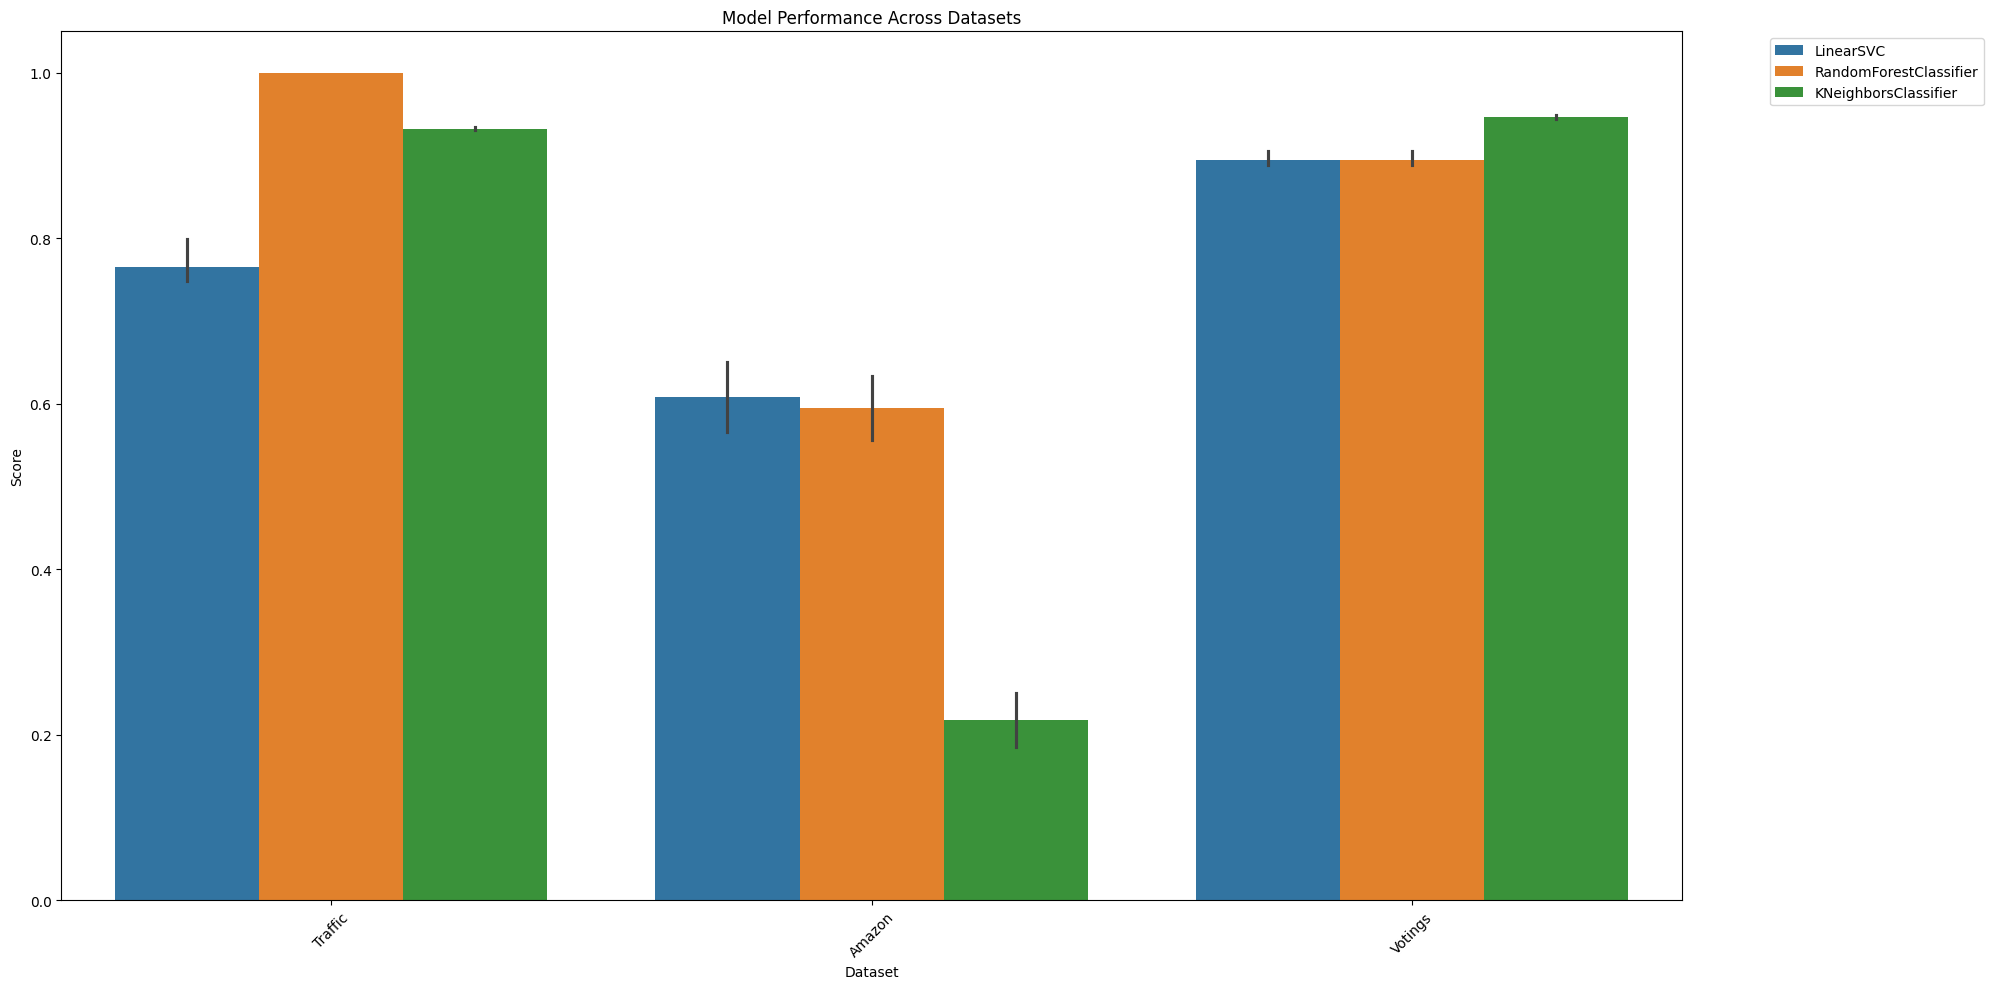

/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


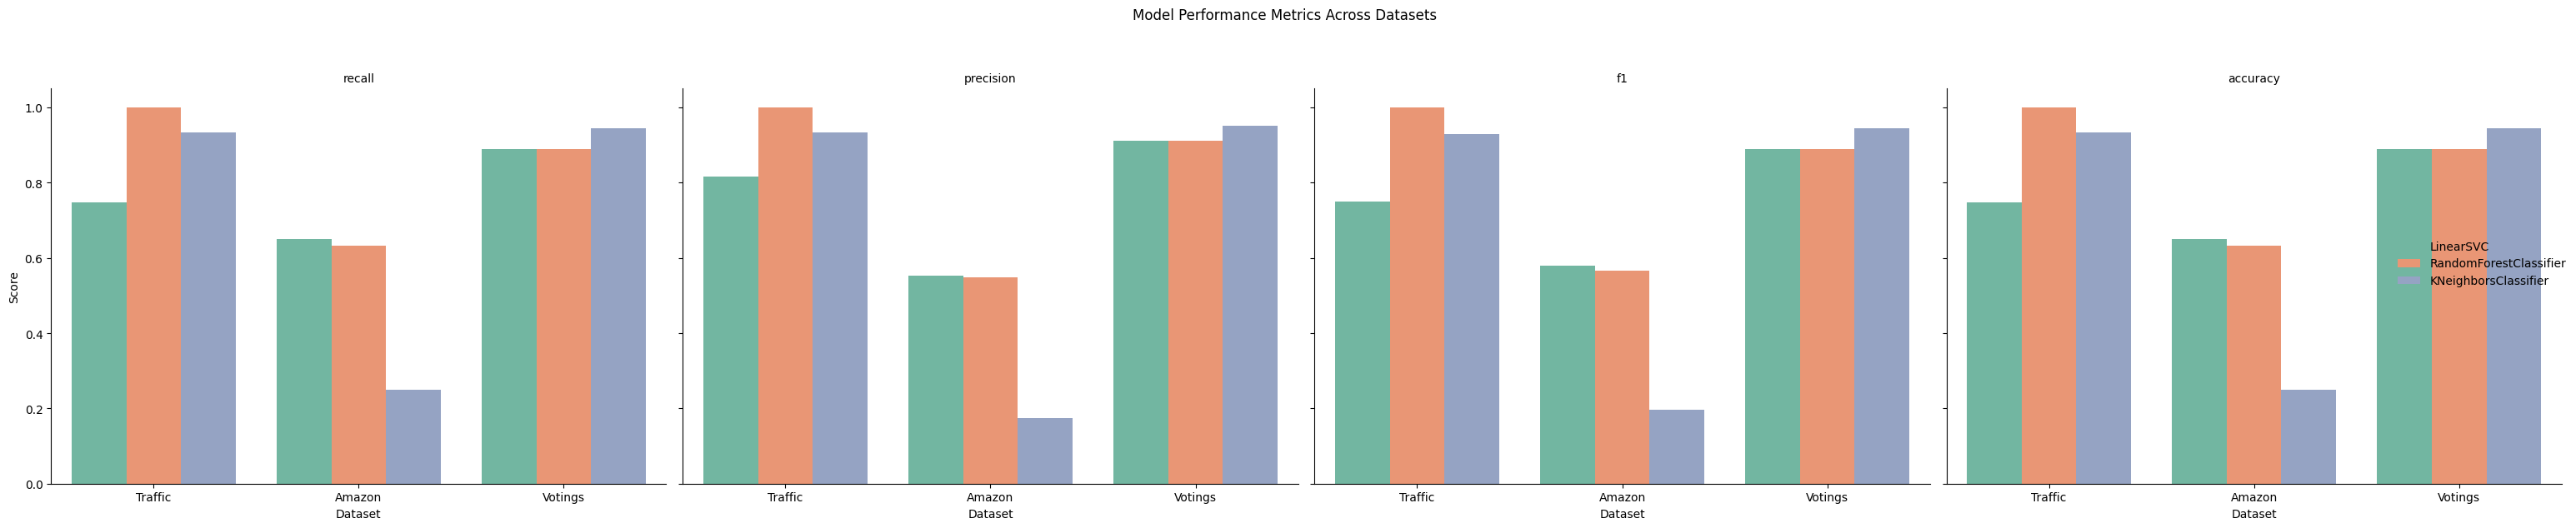

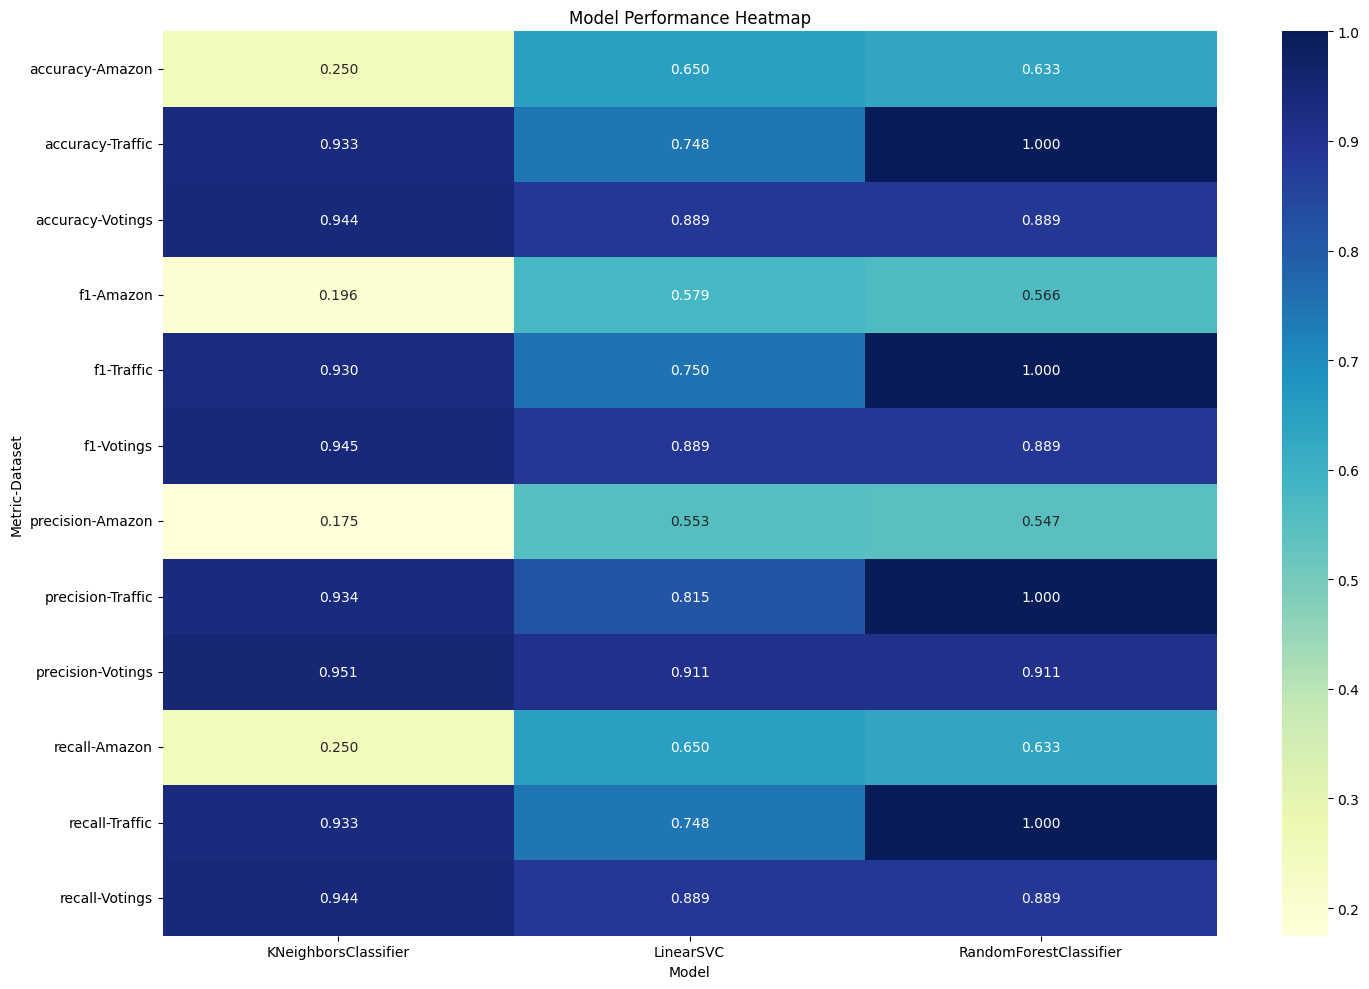

<Figure size 1500x1200 with 0 Axes>

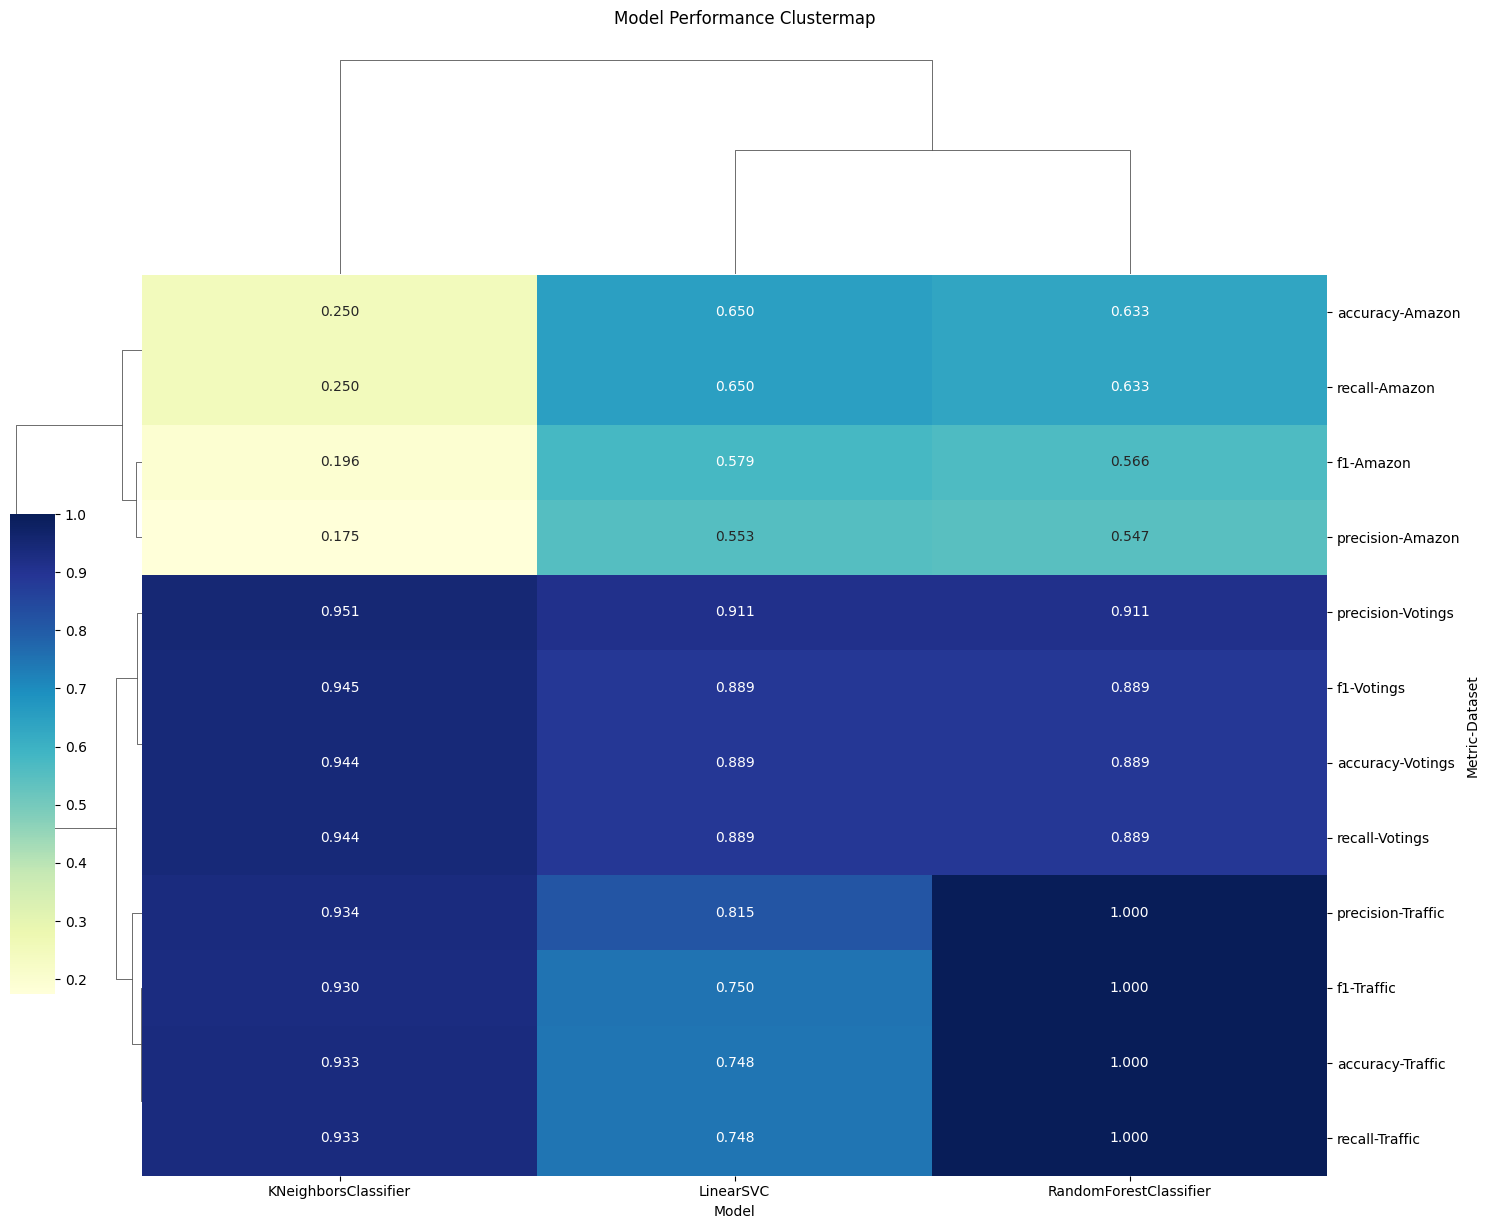

In [ ]:
# Reset index for easier plotting
df_plot = df_results.copy()

# Create the overall plot
plt.figure(figsize=(20, 10))
sns.barplot(x='Dataset', y='Score', hue='Model', data=df_plot)
plt.title("Model Performance Across Datasets")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Create facet grid for each metric
g = sns.FacetGrid(df_plot, col="Metric", height=6, aspect=1.2)
g.map(sns.barplot, "Dataset", "Score", "Model", palette="Set2")
g.add_legend()
g.fig.suptitle("Model Performance Metrics Across Datasets", y=1.05)
g.set_axis_labels("Dataset", "Score")
g.set_titles("{col_name}")
plt.tight_layout()
plt.show()

# Create heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Model Performance Heatmap")
plt.tight_layout()
plt.show()

# Create clustermap
plt.figure(figsize=(15, 12))
cluster = sns.clustermap(pivot_table, 
                         annot=True, 
                         cmap="YlGnBu", 
                         fmt=".3f",
                         figsize=(15, 12),
                         dendrogram_ratio=(.1, .2),
                         cbar_pos=(0.01, .2, .03, .4))
cluster.fig.suptitle("Model Performance Clustermap", y=1.02)
plt.show()

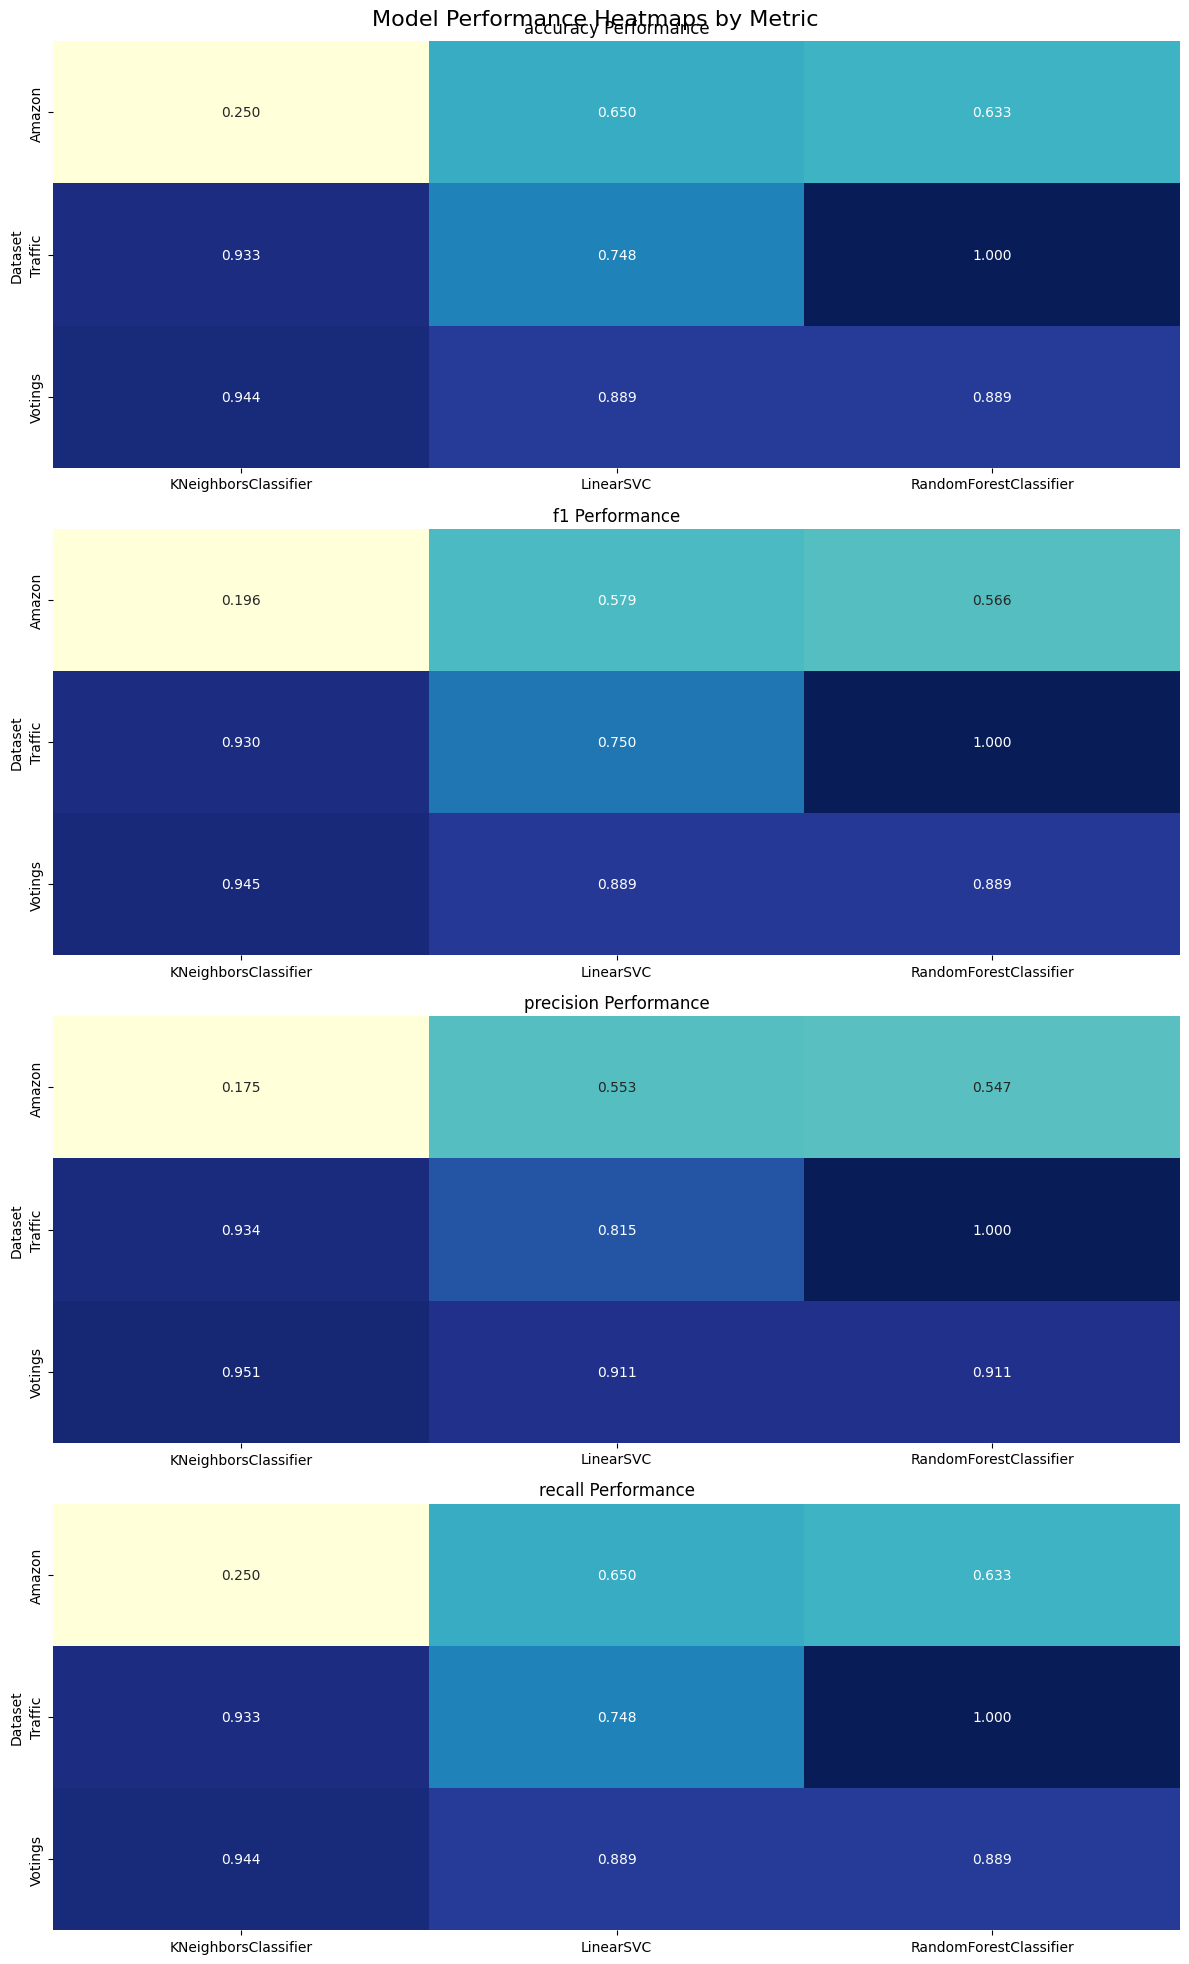

<Figure size 1000x800 with 0 Axes>

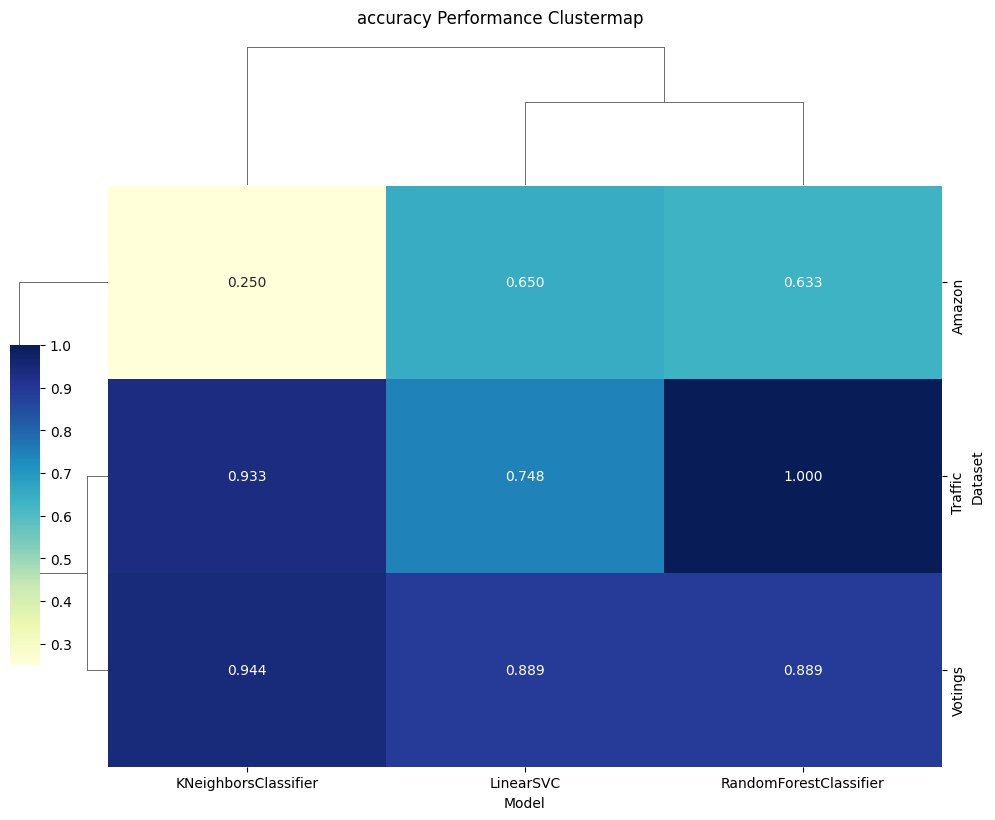

<Figure size 1000x800 with 0 Axes>

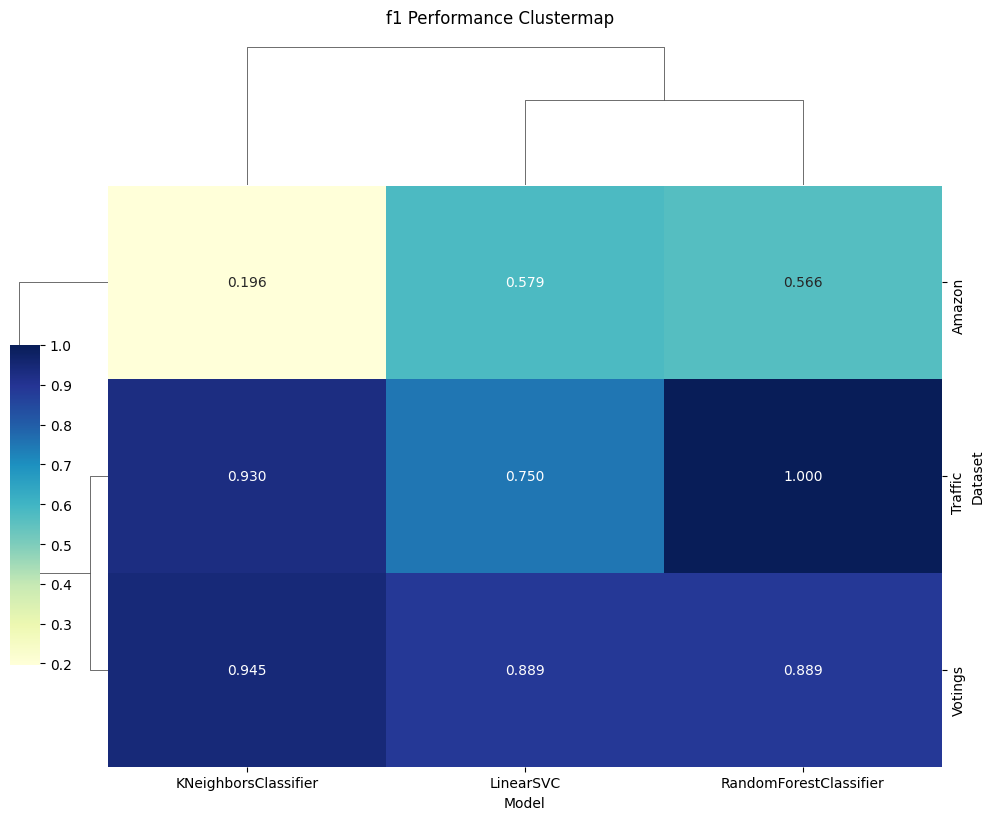

<Figure size 1000x800 with 0 Axes>

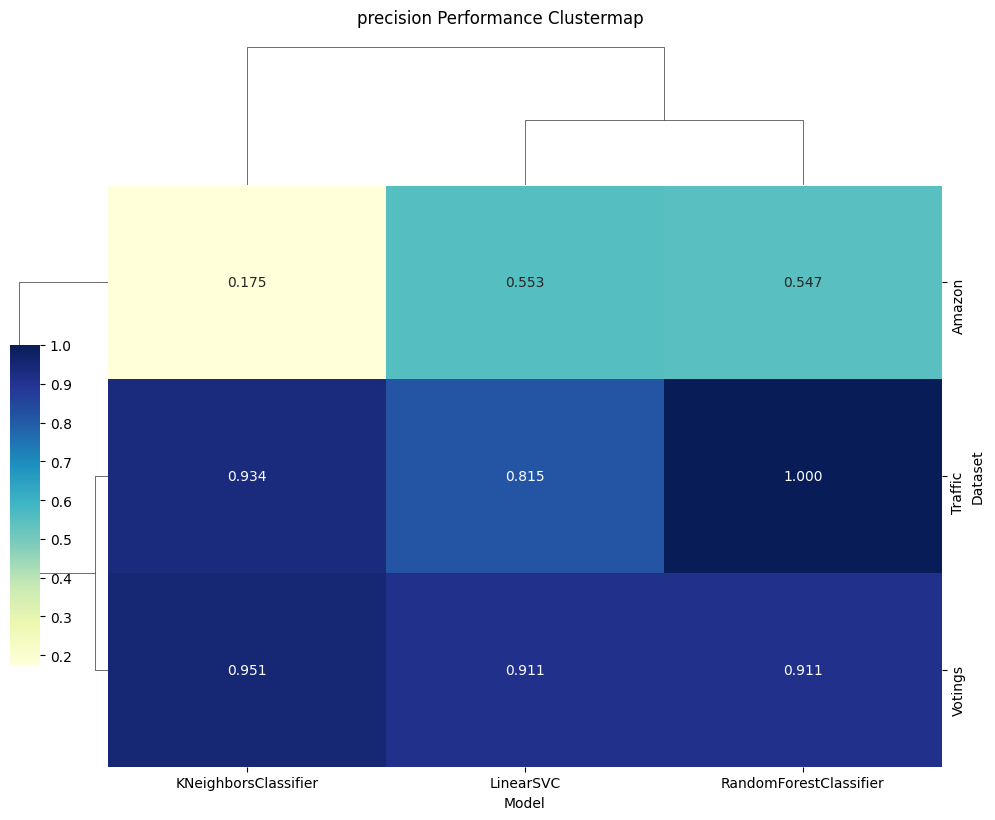

<Figure size 1000x800 with 0 Axes>

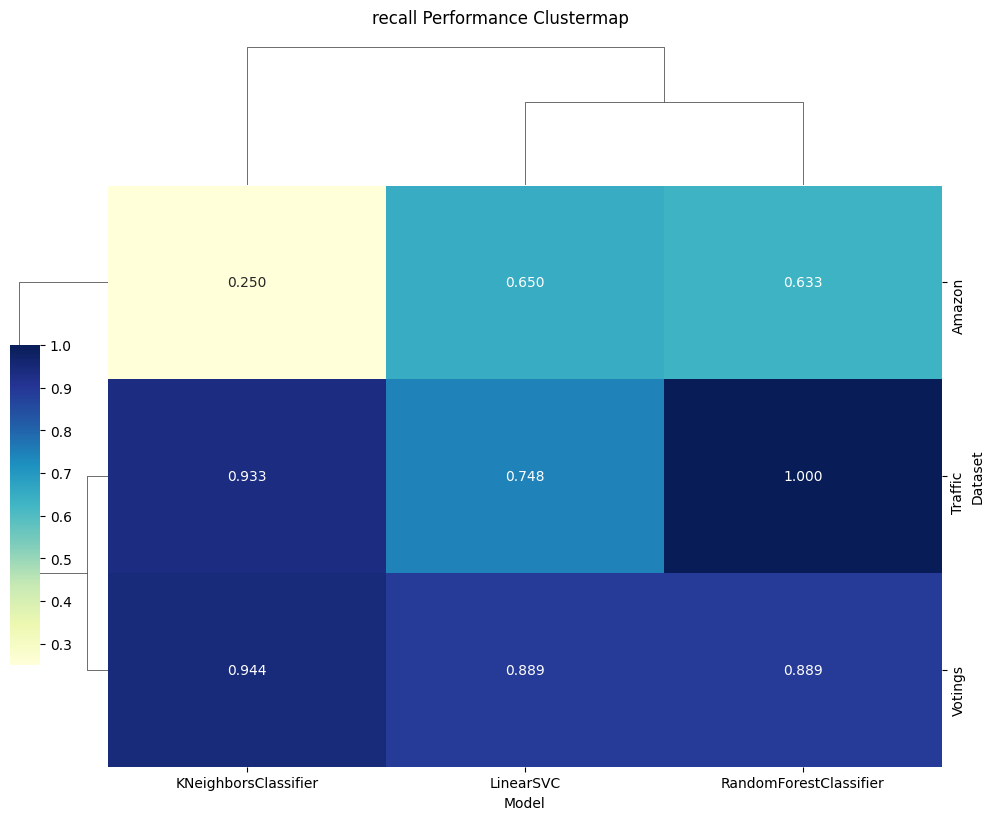

In [ ]:
# Create pivot table
pivot_table = df_results.pivot_table(values='Score', 
                                     index='Dataset', 
                                     columns=['Metric', 'Model'])
# Separate heatmaps for each metric
metrics = pivot_table.columns.get_level_values('Metric').unique()

fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 5*len(metrics)))
fig.suptitle("Model Performance Heatmaps by Metric", fontsize=16)

for i, metric in enumerate(metrics):
    sns.heatmap(pivot_table[metric], annot=True, cmap="YlGnBu", fmt=".3f", 
                ax=axes[i], cbar=False)
    axes[i].set_title(f"{metric} Performance")
    axes[i].set_xlabel('')
    
plt.tight_layout()
plt.show()

# Clustermaps grouped by metric
for metric in metrics:
    plt.figure(figsize=(10, 8))
    cluster = sns.clustermap(pivot_table[metric], 
                             annot=True, 
                             cmap="YlGnBu", 
                             fmt=".3f",
                             figsize=(10, 8),
                             dendrogram_ratio=(.1, .2),
                             cbar_pos=(0.01, .2, .03, .4))
    cluster.fig.suptitle(f"{metric} Performance Clustermap", y=1.02)
    plt.show()

In [43]:
print(pivot_table.index.name)
print(pivot_table.columns)
print(pivot_table)

None
Index(['KNeighborsClassifier', 'LinearSVC', 'RandomForestClassifier'], dtype='object', name='Model')
Model              KNeighborsClassifier  LinearSVC  RandomForestClassifier
Metric    Dataset                                                         
accuracy  Amazon               0.250000   0.650000                0.633333
          Traffic              0.932773   0.747899                1.000000
          Votings              0.944444   0.888889                0.888889
          Wine                 0.859284   0.855475                0.468445
f1        Amazon               0.196190   0.579444                0.565556
          Traffic              0.930044   0.750401                1.000000
          Votings              0.944616   0.888889                0.888889
          Wine                 0.856888   0.859123                0.529455
precision Amazon               0.174722   0.552778                0.547222
          Traffic              0.934267   0.815368                1.0

# 4. Explore different scaling approaches

In [44]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


def fit_pipeline_with_scaling_against_metric(
        X_train: pd.DataFrame,
        y_train: pd.DataFrame,
        X_valid: pd.DataFrame,
        y_valid: pd.DataFrame,
        model_class: type,
        scaler_class: type) -> typing.Dict[str, float]:
  # build a sklearn pipeline using the scaler and the model
  # train the pipeline, and predict on the valid data
  # calculate the performance using the metric_func on the predictions and y_valid
  # return the calculated performance
    # Create and fit pipeline
    model = model_class(random_state=42) if model_class != KNeighborsClassifier else model_class()
    if scaler_class is None:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
    else:
        pipeline = make_pipeline(
            scaler_class(),
            model
        )
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_valid)
    scores = compare_metrics(y_valid, y_pred)

    return scores


suitable_scalings = {
    'NoScaling': None,
    'StandardScaler': StandardScaler,
    'MinMaxScaler': MinMaxScaler,
    'RobustScaler': RobustScaler
}

In [ ]:
results = []
for dataset_name, dataset in train_valid_data.items():
    print(f"==============\n{dataset_name}-Dataset")
    for model in suitable_ml_methods:
        for scaler_name, scaler_class in suitable_scalings.items():
            scores = fit_pipeline_with_scaling_against_metric(
                dataset.X_train, 
                dataset.y_train,
                dataset.X_valid,
                dataset.y_valid,
                model,
                scaler_class,
                )
            for metric_name, score in scores.items():
                results.append({
                    'Metric': metric_name,
                    'Model': model.__name__,
                    'Dataset': dataset_name,
                    'Scaling': scaler_name,
                    'Score': score
                })

Traffic-Dataset
Amazon-Dataset


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Create DataFrame
df_results = pd.DataFrame(results)
# next line can be commented/removed
# df_results['Metric'] = df_results['Metric'].apply(lambda x: x.__name__ if callable(x) else x)

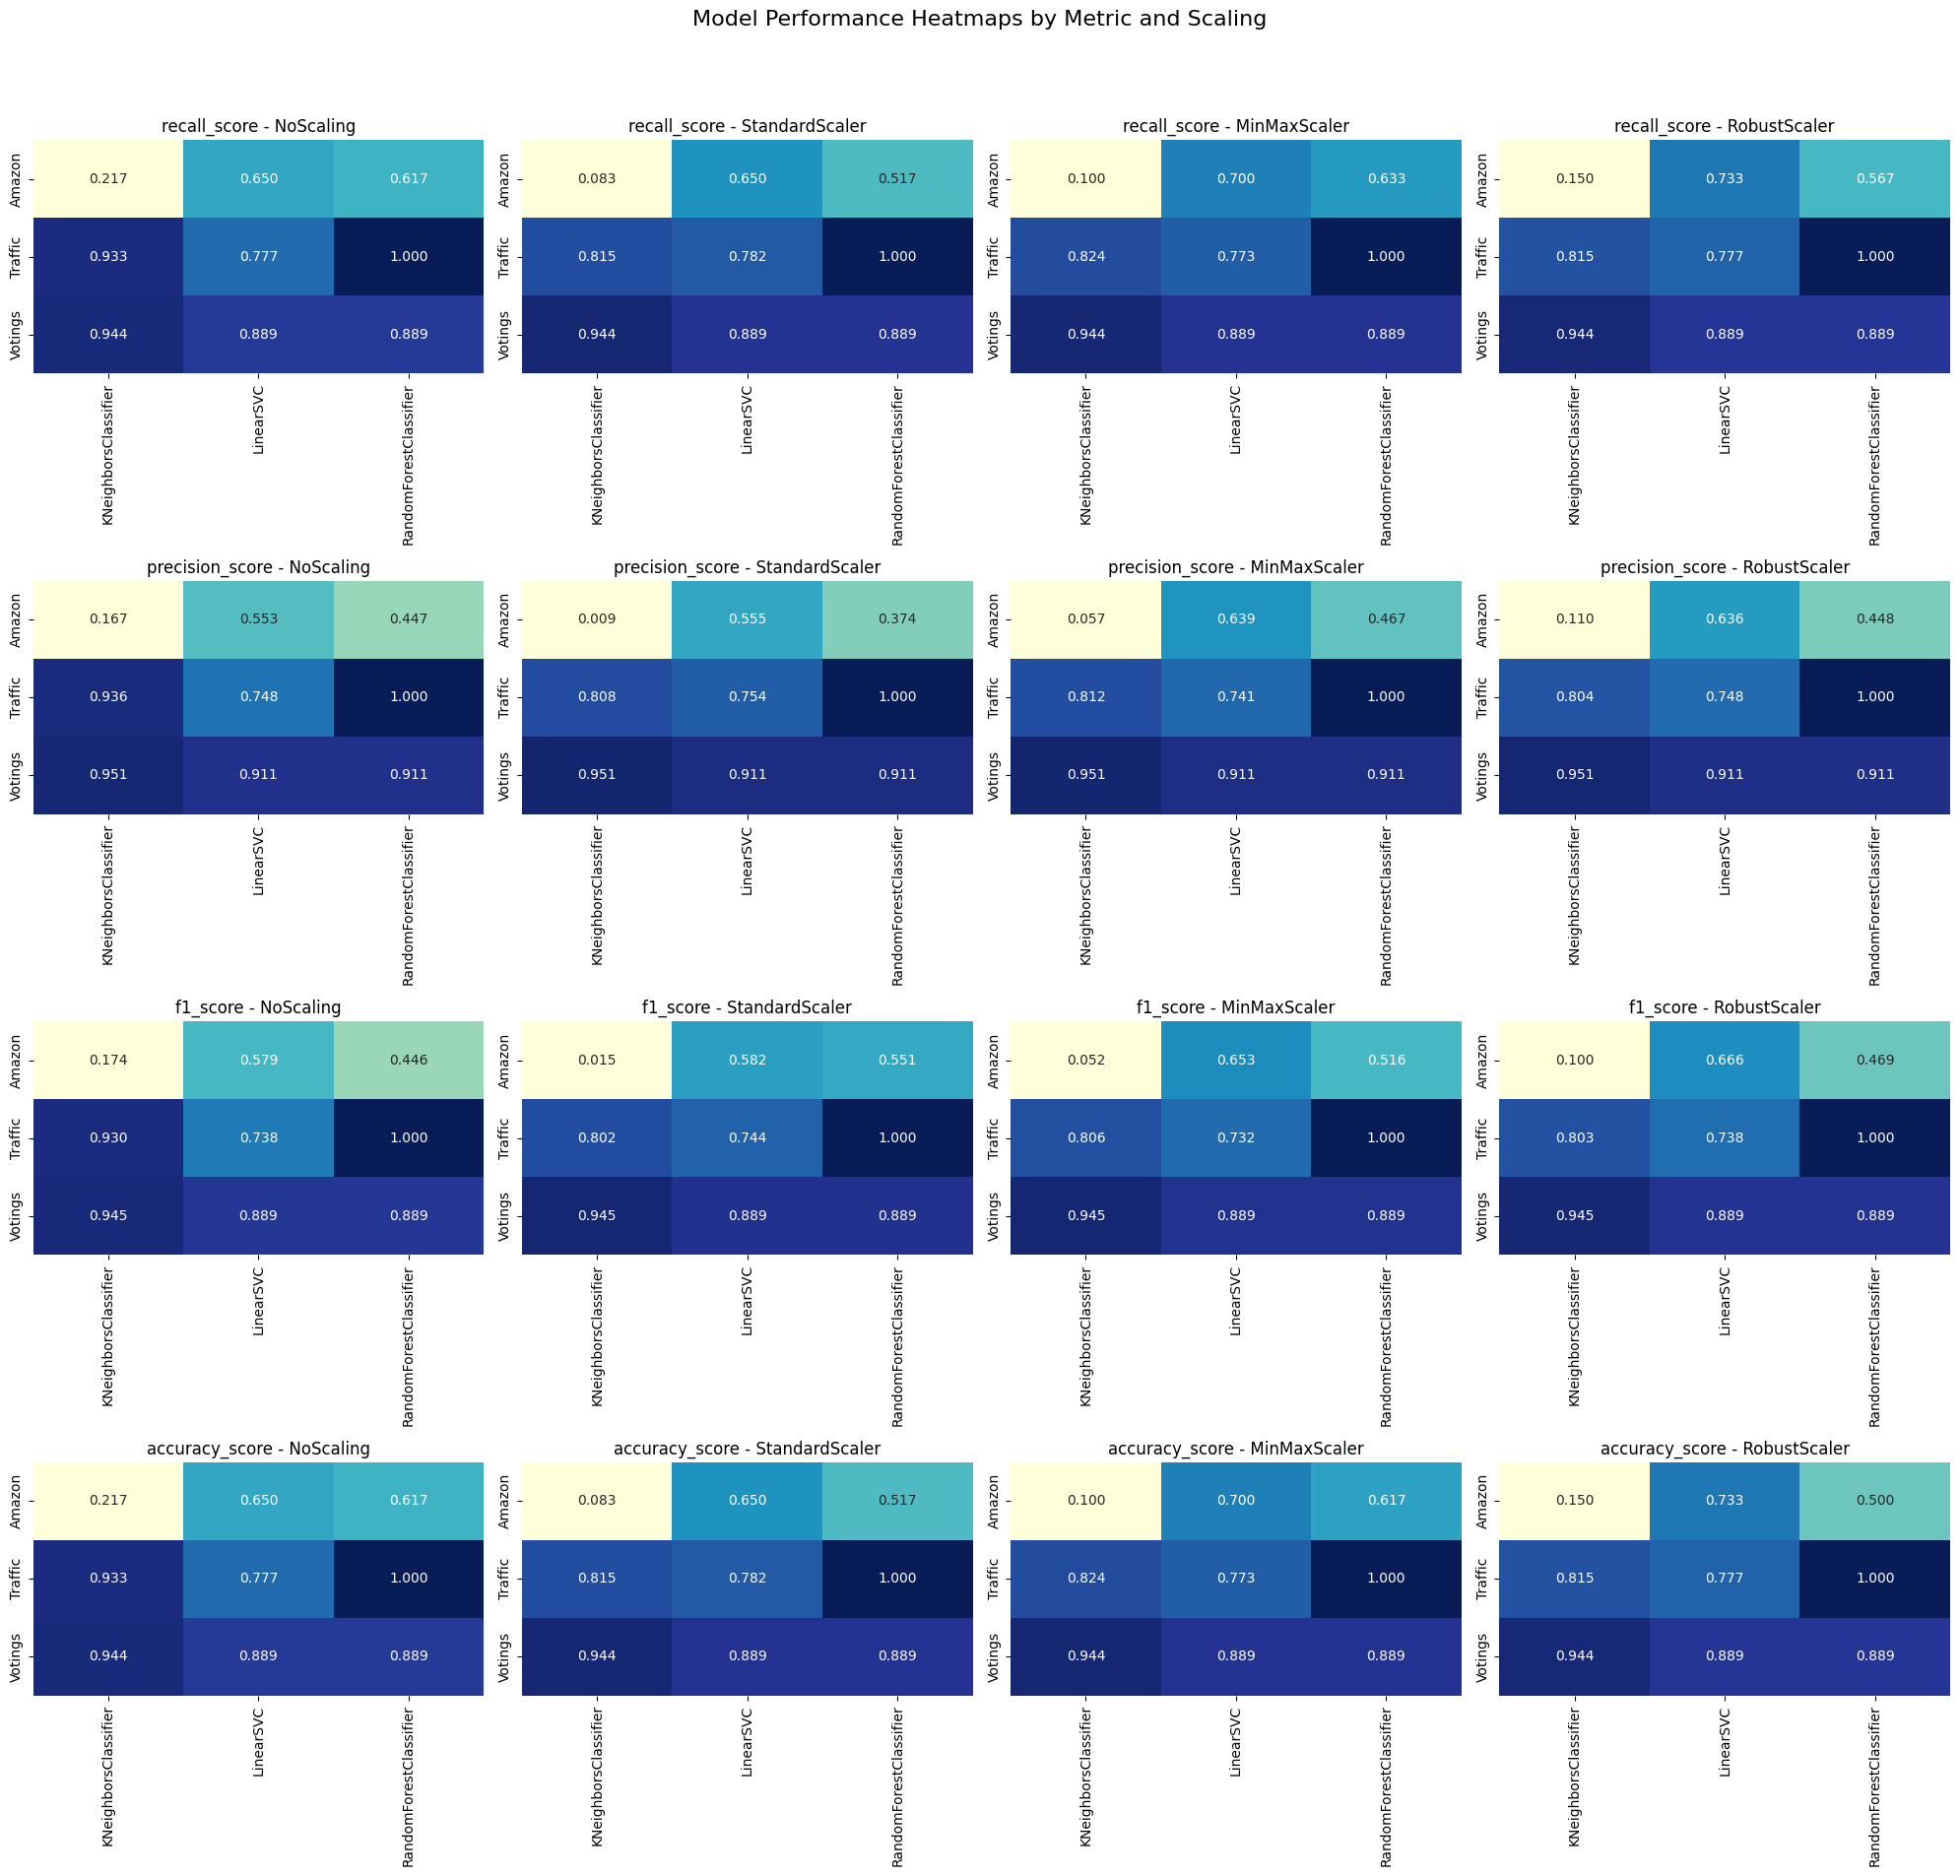

In [ ]:
# 1. Faceted Heatmaps
metrics = df_results['Metric'].unique()
scalings = df_results['Scaling'].unique()

fig, axes = plt.subplots(len(metrics), len(scalings), 
                         figsize=(5*len(scalings), 5*len(metrics)))
fig.suptitle("Model Performance Heatmaps by Metric and Scaling", fontsize=16)

for i, metric in enumerate(metrics):
    for j, scaling in enumerate(scalings):
        data = df_results[(df_results['Metric'] == metric) & 
                          (df_results['Scaling'] == scaling)]
        pivot = data.pivot(index='Dataset', columns='Model', values='Score')
        sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".3f", 
                    ax=axes[i, j], cbar=False)
        axes[i, j].set_title(f"{metric} - {scaling}")
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



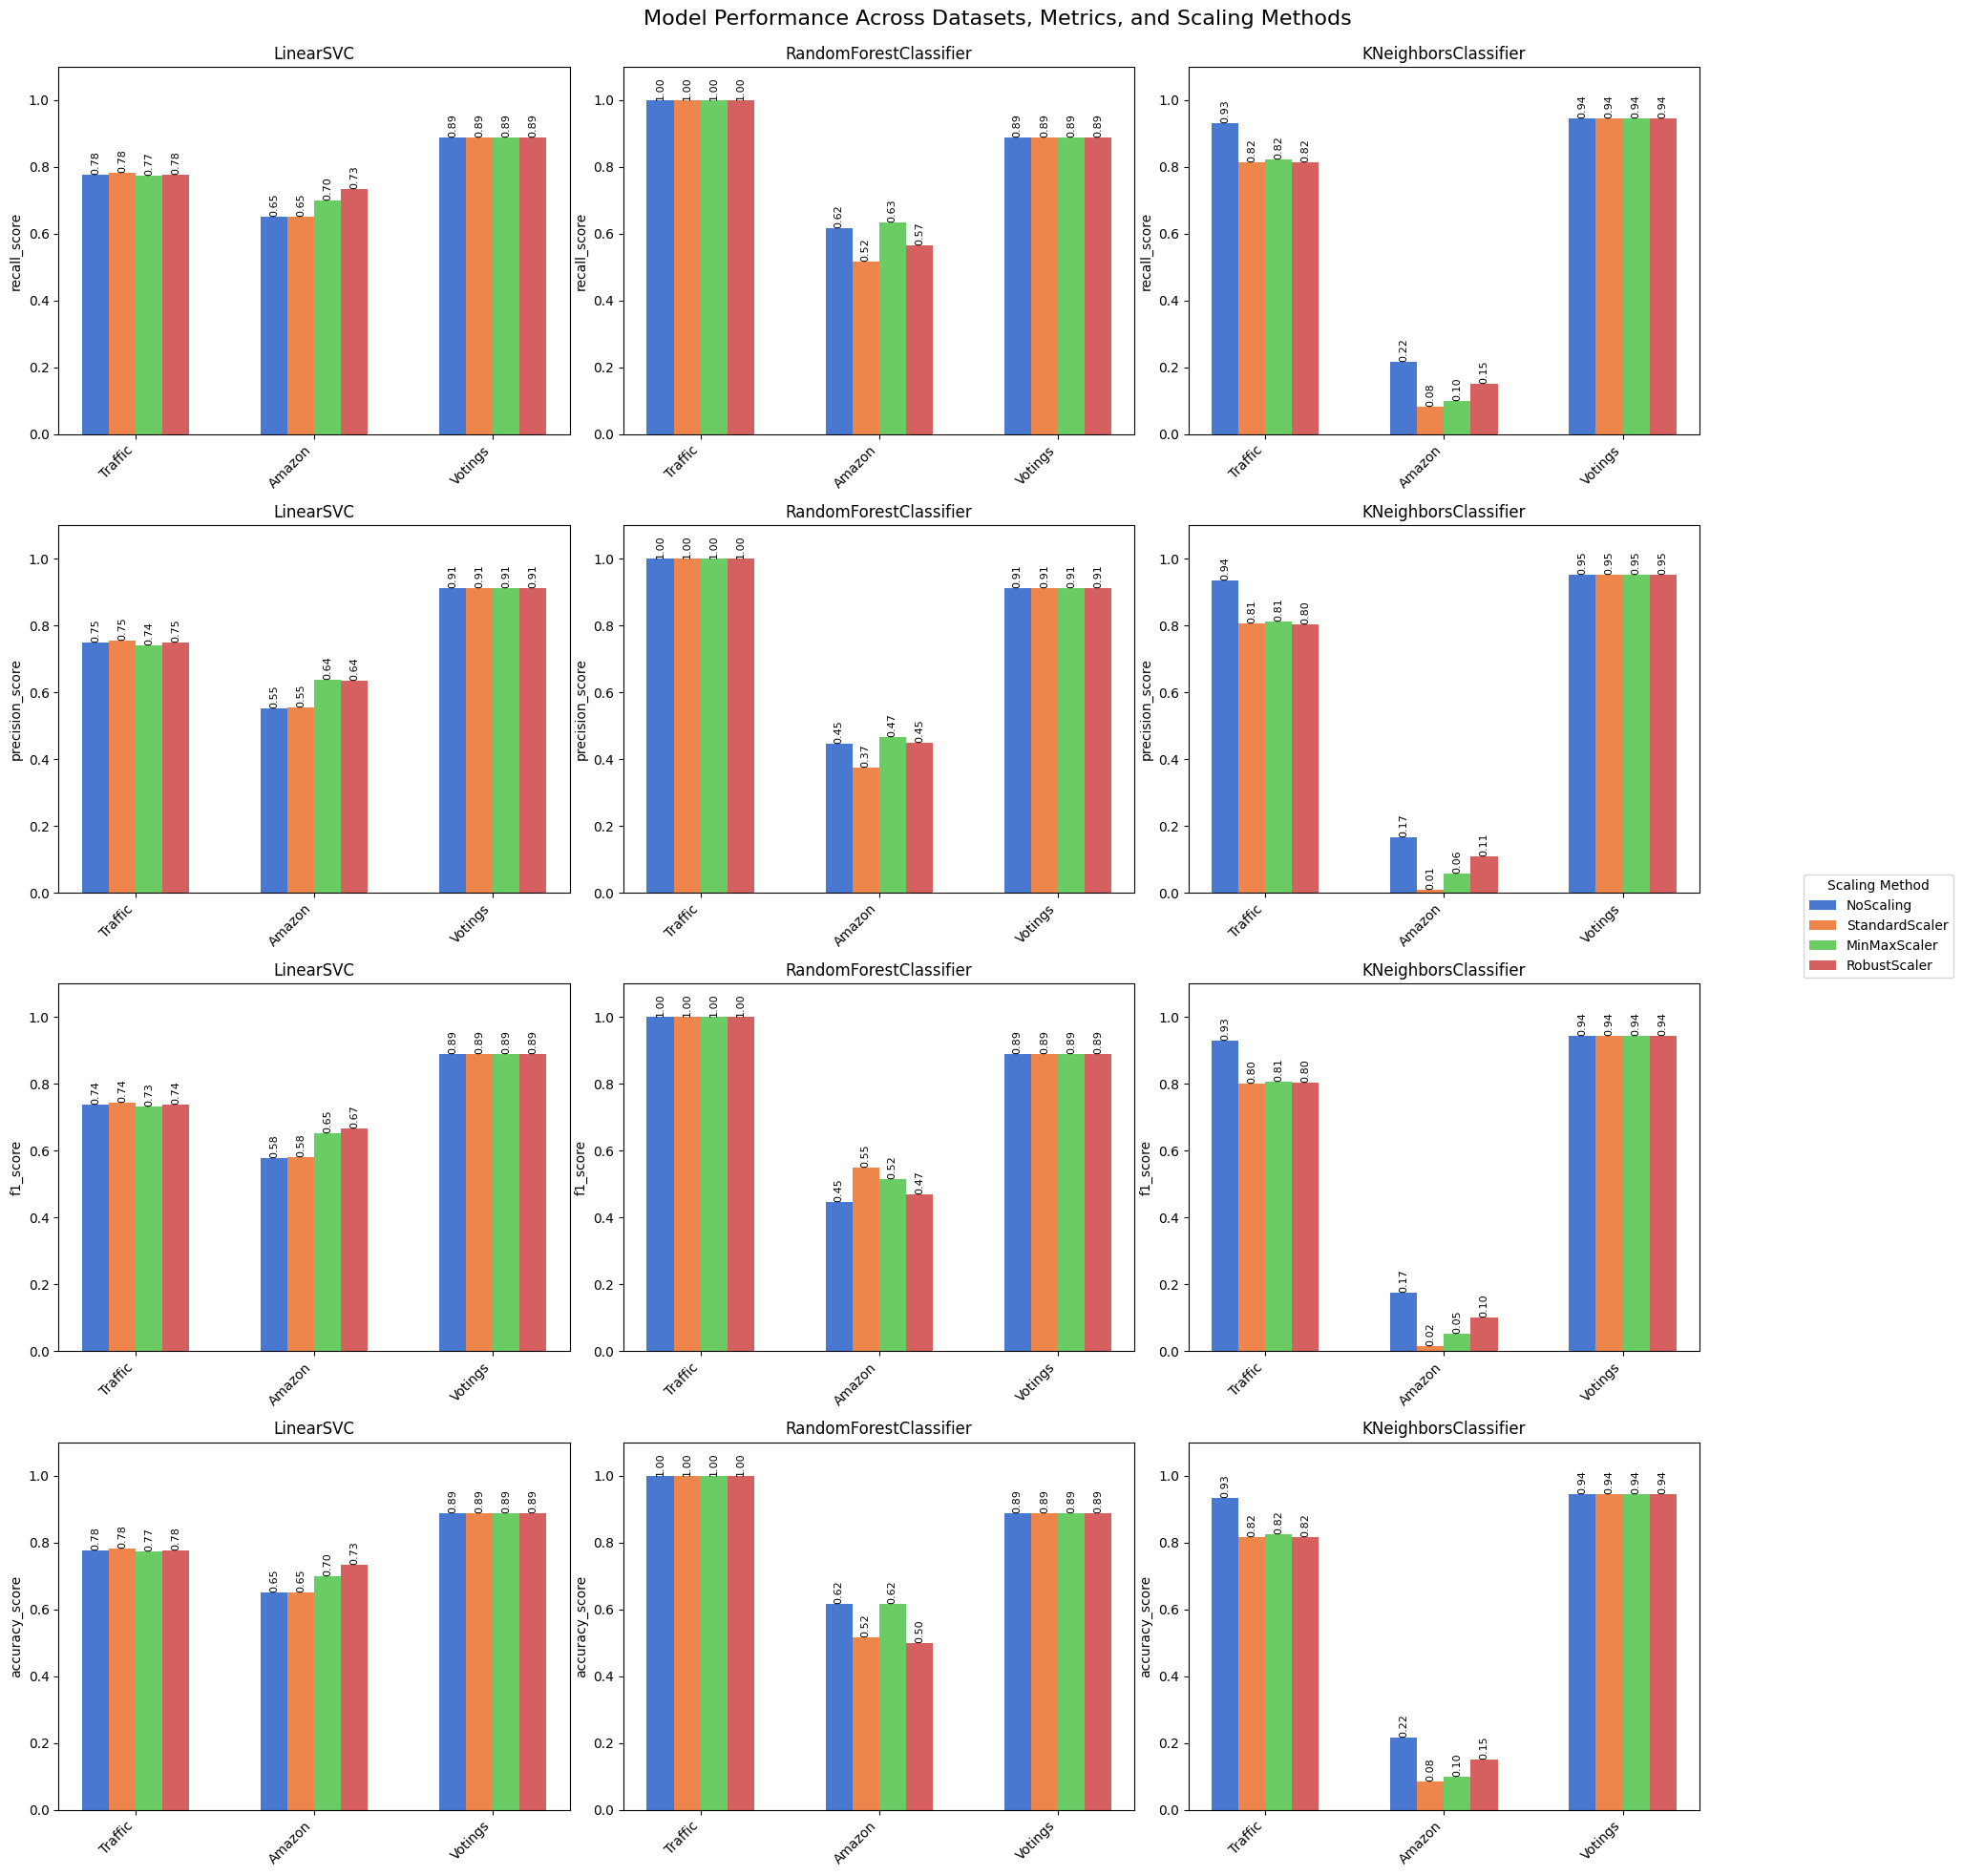

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Define number of subplots per row
n_subplots_per_row = 4

metrics = df_results['Metric'].unique()
classifiers = df_results['Model'].unique()
datasets = df_results['Dataset'].unique()
scalings = df_results['Scaling'].unique()

n_rows = len(metrics)

fig, axes = plt.subplots(n_rows, n_subplots_per_row, figsize=(7*n_subplots_per_row, 5*n_rows))
fig.suptitle("Model Performance Across Datasets, Metrics, and Scaling Methods", fontsize=16)

scaling_palette = sns.color_palette("muted", n_colors=len(scalings))
scaling_color_dict = dict(zip(scalings, scaling_palette))

for i, metric in enumerate(metrics):
    for j, classifier in enumerate(classifiers):
        ax = axes[i, j % n_subplots_per_row]
        data = df_results[(df_results['Metric'] == metric) & (df_results['Model'] == classifier)]

        bar_width = 0.15
        group_width = len(scalings) * bar_width
        x = np.arange(len(datasets))

        for k, dataset in enumerate(datasets):
            for m, scaling in enumerate(scalings):
                subset = data[(data['Dataset'] == dataset) & (data['Scaling'] == scaling)]
                if not subset.empty:
                    bar_position = x[k] + (m - (len(scalings)-1)/2) * bar_width
                    bar = ax.bar(bar_position, subset['Score'], bar_width, 
                                 color=scaling_color_dict[scaling],
                                 label=scaling)
                    
                    for rect in bar:
                        height = rect.get_height()
                        ax.text(rect.get_x() + rect.get_width()/2., height,
                                f'{height:.2f}', ha='center', va='bottom', rotation=90, fontsize=8)

        ax.set_ylabel(f'{metric}')
        ax.set_title(f"{classifier}")
        ax.set_xticks(x)
        ax.set_xticklabels(datasets, rotation=45, ha='right')
        ax.set_ylim(0, 1.1)

# Remove any unused subplots
for i in range(n_rows):
    for j in range(len(classifiers), n_subplots_per_row):
        fig.delaxes(axes[i, j])

# Create a single legend for all plots without duplicates
handles, labels = axes[0, 0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), title='Scaling Method', loc='center right', bbox_to_anchor=(0.98, 0.5))

plt.tight_layout()
plt.subplots_adjust(right=0.85, top=0.95)
plt.show()

In [ ]:
# Print summary statistics
print(df_results.groupby(['Metric', 'Model', 'Scaling'])['Score'].describe())

                                                       count      mean  \
Metric          Model                  Scaling                           
accuracy_score  KNeighborsClassifier   MinMaxScaler      3.0  0.622658   
                                       NoScaling         3.0  0.697961   
                                       RobustScaler      3.0  0.636523   
                                       StandardScaler    3.0  0.614301   
                LinearSVC              MinMaxScaler      3.0  0.787333   
                                       NoScaling         3.0  0.772067   
                                       RobustScaler      3.0  0.799844   
                                       StandardScaler    3.0  0.773467   
                RandomForestClassifier MinMaxScaler      3.0  0.835185   
                                       NoScaling         3.0  0.835185   
                                       RobustScaler      3.0  0.796296   
                                      

# 5. Experiment with different train/valid splits

In [ ]:
# Try different train-valid splits
suitable_split_ratios = {
    'split_90_10': 0.1,
    'split_80_20': 0.2,
    'split_70_30': 0.3,
    'split_60_40': 0.4
}

In [ ]:
def compare_train_valid_splits(df:pd.DataFrame, model_class, target_class:str, valid_size:float) -> typing.Dict[str, float]:

    # Split train-valid
    X_train, y_train, X_valid, y_valid = split_data_train_valid(
        df,
        valid_size=valid_size,
        target_class=target_class
    )
    
    # Train model
    model = model_class(random_state=42) if model_class != KNeighborsClassifier else model_class()
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_valid)
    
    scores = compare_metrics(y_valid, y_pred)
    
    return scores

In [ ]:
# todo pw: call compare_train_valid_splits()
results_train_valid = []
for dataset_name, dataset in train_data.items():
    print(f"==============\n{dataset_name}-Dataset")
    for model in suitable_ml_methods:
        for split_name, split_ratio in suitable_split_ratios.items():
            scores = compare_train_valid_splits(
                dataset,
                model,
                target_classes[dataset_name],
                split_ratio,
                )
            for metric_name, score in scores.items():
                results_train_valid.append({
                    'Metric': metric_name,
                    'Model': model.__name__,
                    'Dataset': dataset_name,
                    'SplitRatio': split_name,
                    'Score': score
                })

Traffic-Dataset
Amazon-Dataset


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: Converg

Votings-Dataset


In [ ]:


# Convert results to DataFrame
df_results = pd.DataFrame(results_train_valid)

# Create pivot table for heatmap
pivot_table = df_results.pivot_table(values='Score', 
                                     index=['Metric', 'Model'], 
                                     columns=['Dataset', 'SplitRatio'])



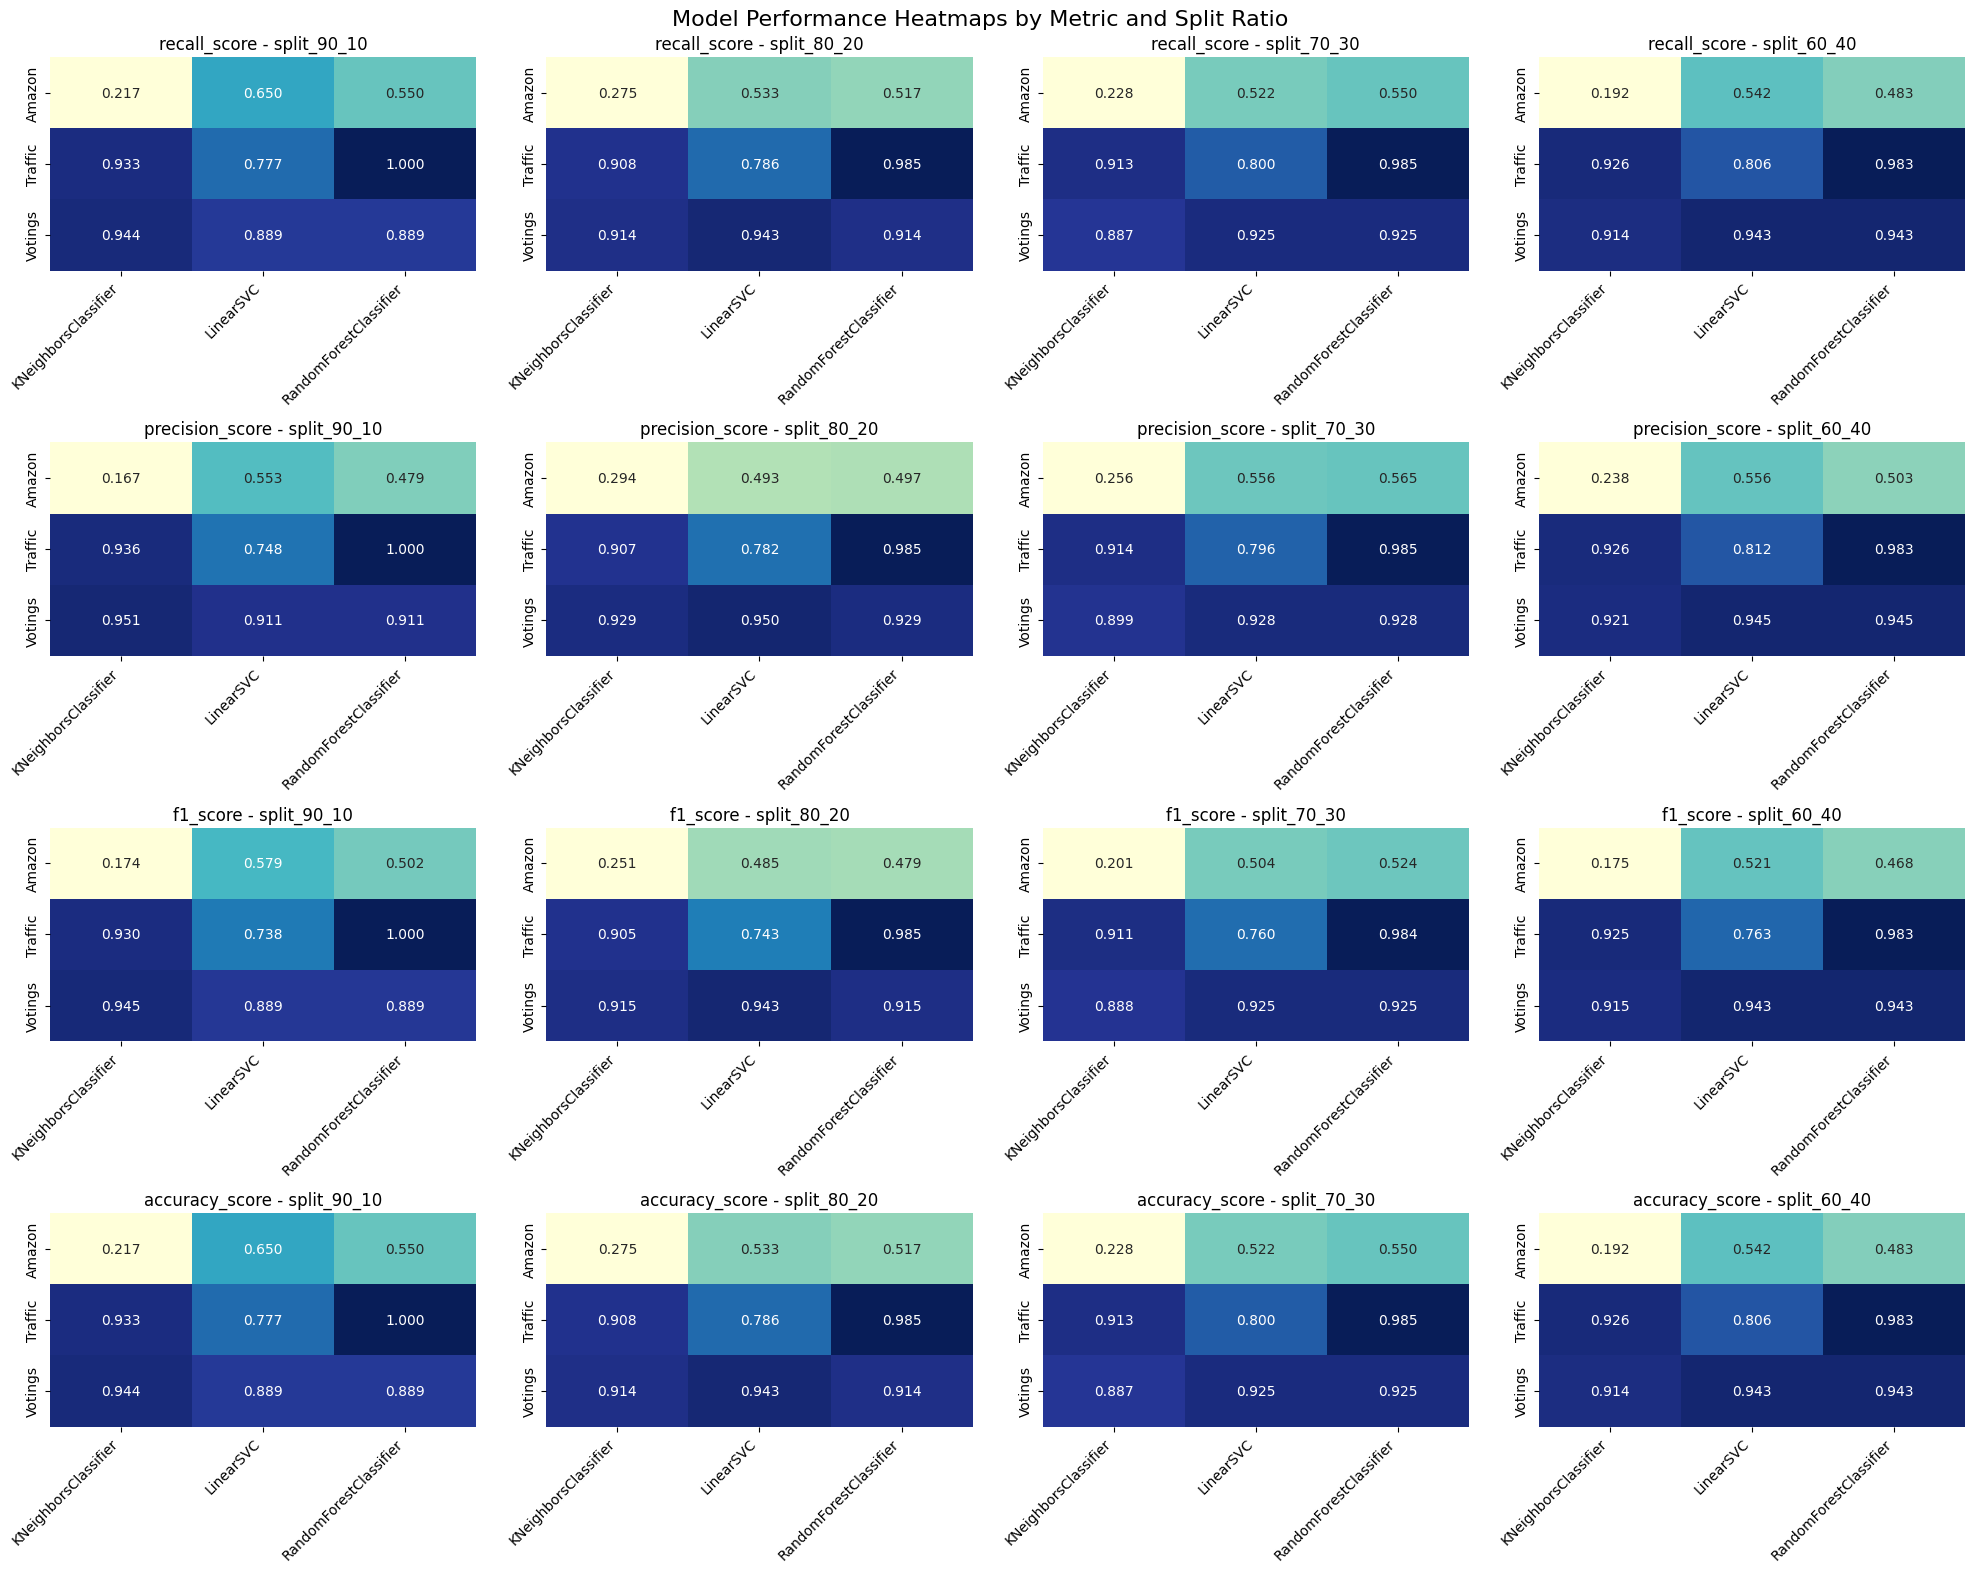

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Convert results to DataFrame
df_results = pd.DataFrame(results_train_valid)

# Get unique values
metrics = df_results['Metric'].unique()
classifiers = df_results['Model'].unique()
datasets = df_results['Dataset'].unique()
split_ratios = df_results['SplitRatio'].unique()

# Create figure with subplots
fig, axes = plt.subplots(len(metrics), len(split_ratios), 
                         figsize=(5*len(split_ratios), 4*len(metrics)))
fig.suptitle("Model Performance Heatmaps by Metric and Split Ratio", fontsize=16)

# Flatten axes array if there's only one row
if len(metrics) == 1:
    axes = axes.reshape(1, -1)

for i, metric in enumerate(metrics):
    for j, ratio in enumerate(split_ratios):
        data = df_results[(df_results['Metric'] == metric) & 
                          (df_results['SplitRatio'] == ratio)]
        
        # Create pivot table for this subplot
        pivot = data.pivot(index='Dataset', columns='Model', values='Score')
        
        # Create heatmap
        sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".3f", 
                    ax=axes[i, j], cbar=False)
        
        axes[i, j].set_title(f"{metric} - {ratio}")
        
        # Remove x and y labels
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')
        
        # Rotate x-axis labels
        axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), rotation=45, ha='right')

# Remove any unused subplots
for i in range(len(metrics)):
    for j in range(len(split_ratios), axes.shape[1]):
        fig.delaxes(axes[i, j])

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# Show plot
plt.show()

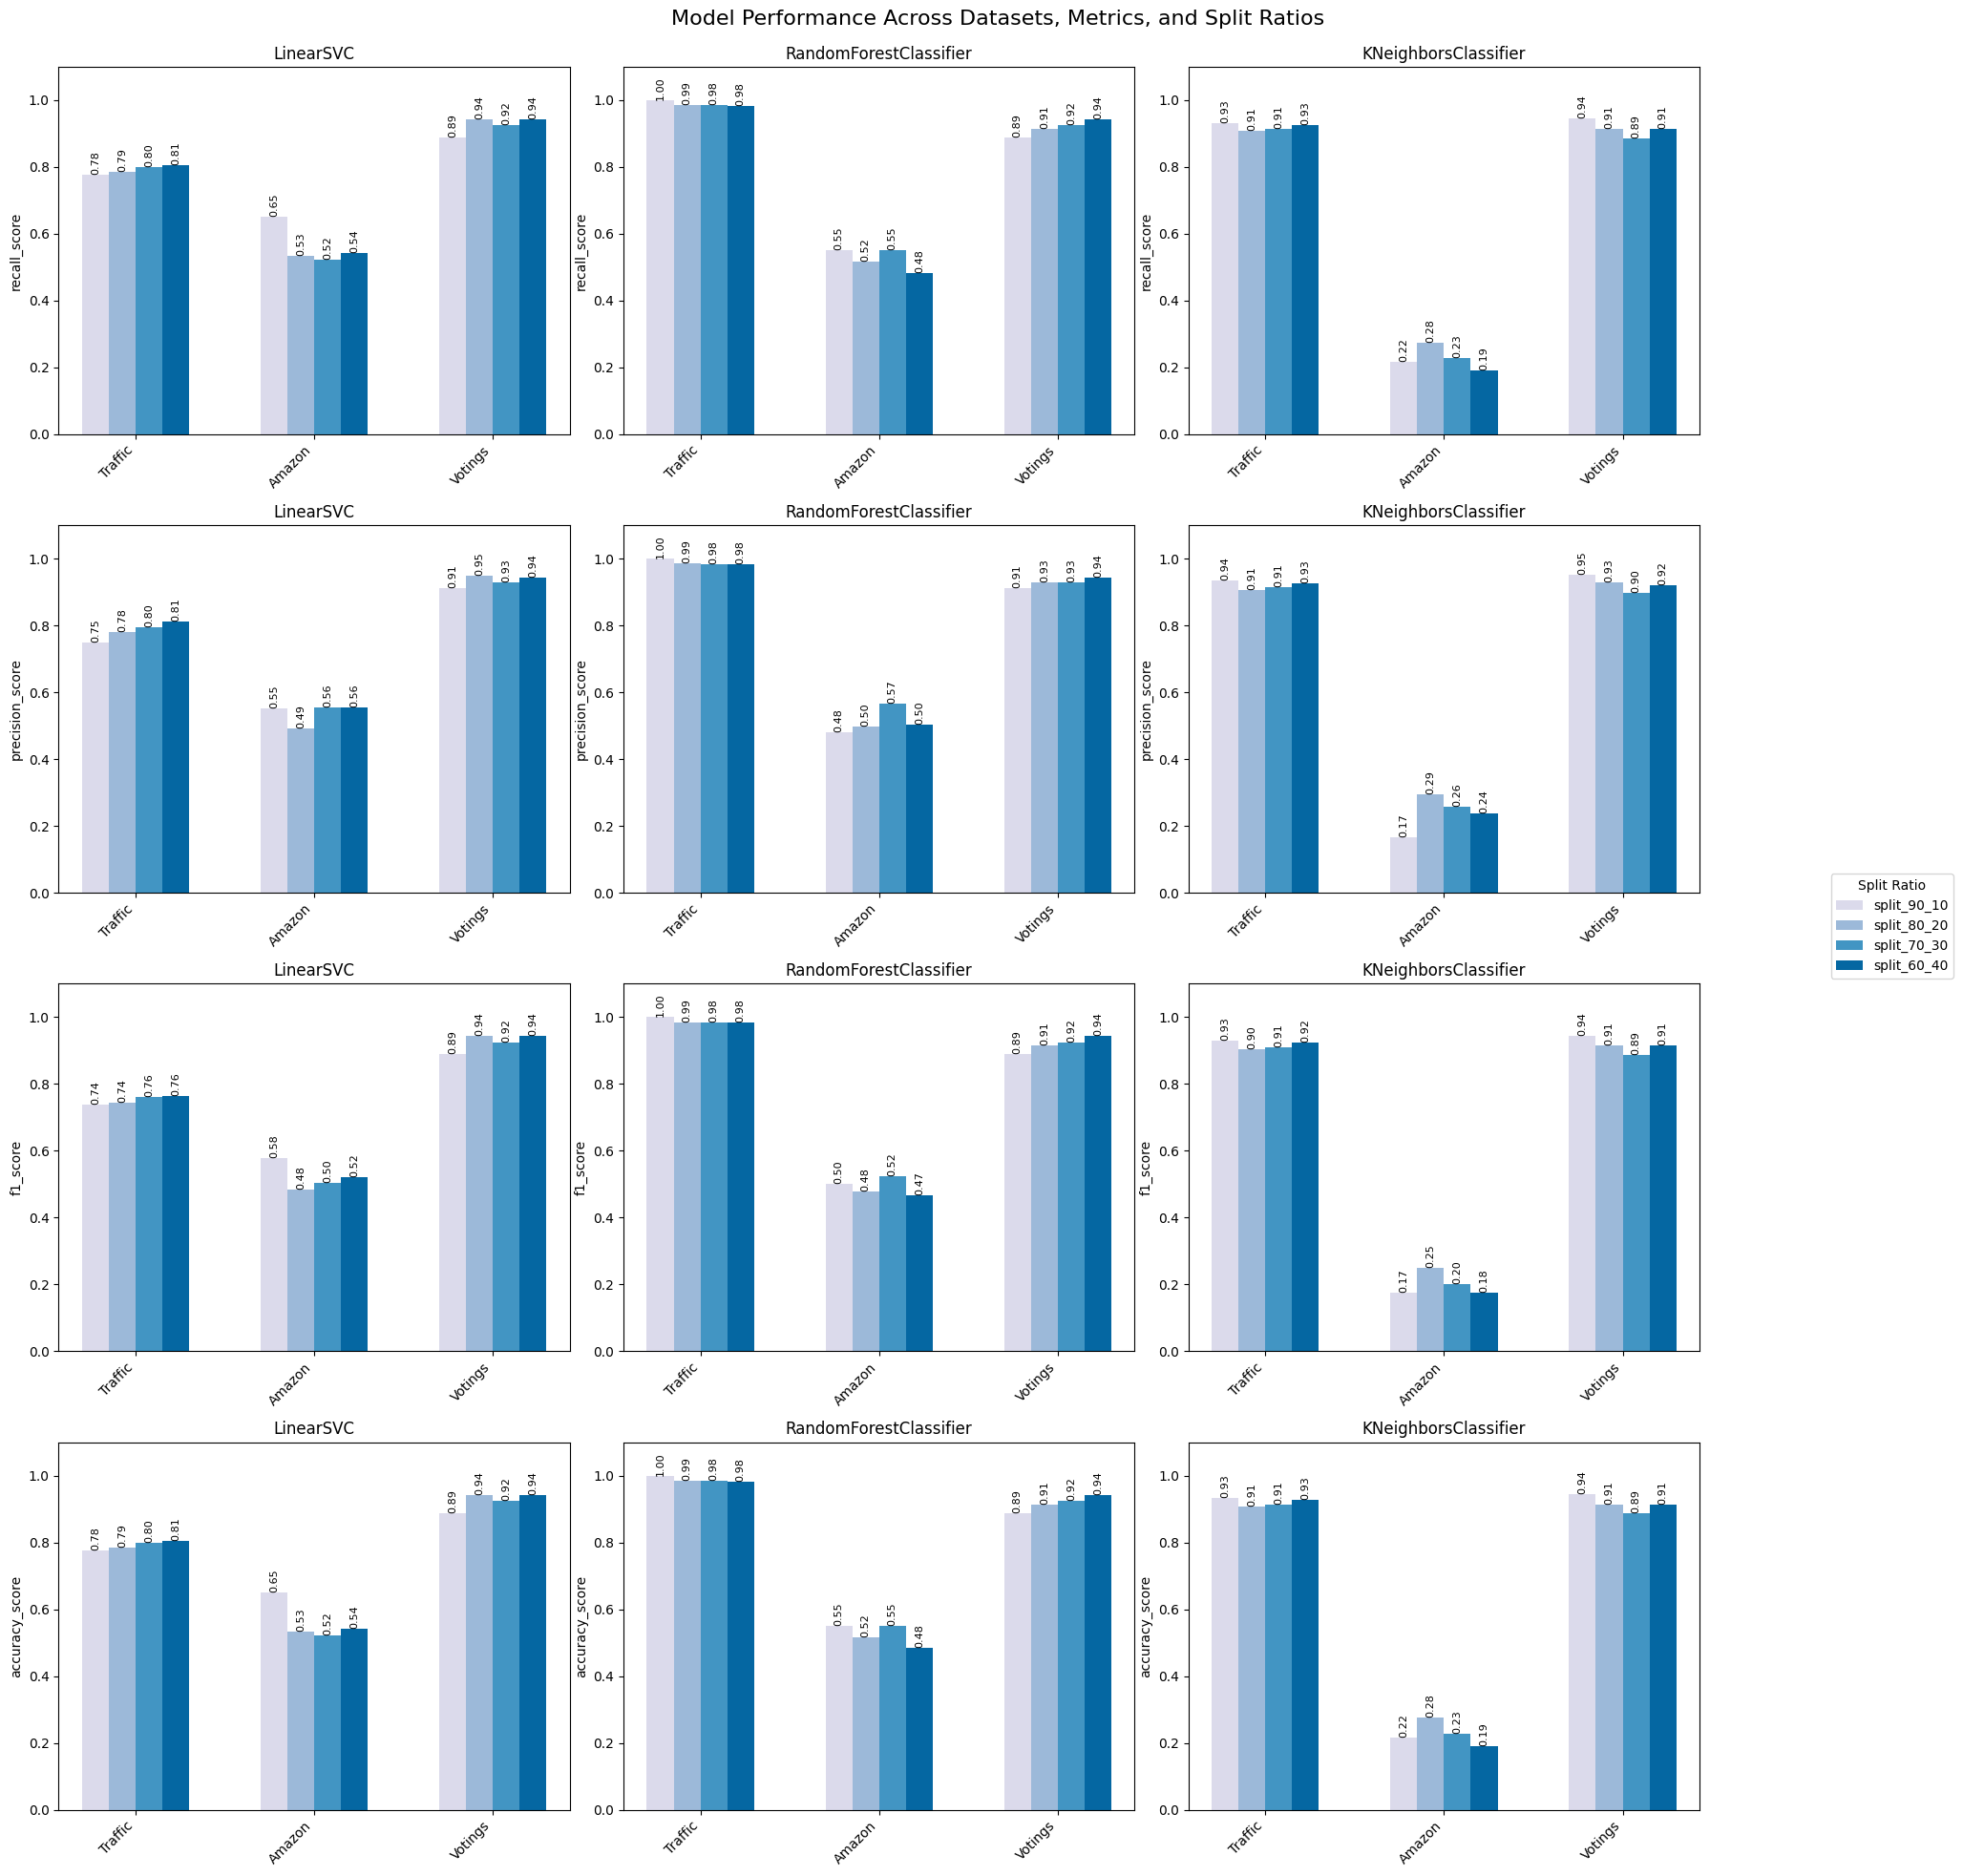

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Convert results to DataFrame
df_results = pd.DataFrame(results_train_valid)

# Define number of subplots per row
n_subplots_per_row = 4

metrics = df_results['Metric'].unique()
classifiers = df_results['Model'].unique()
datasets = df_results['Dataset'].unique()
split_ratios = df_results['SplitRatio'].unique()

n_rows = len(metrics)

fig, axes = plt.subplots(n_rows, n_subplots_per_row, figsize=(7*n_subplots_per_row, 5*n_rows))
fig.suptitle("Model Performance Across Datasets, Metrics, and Split Ratios", fontsize=16)

split_ratio_palette = sns.color_palette("PuBu", n_colors=len(split_ratios))
split_ratio_color_dict = dict(zip(split_ratios, split_ratio_palette))

for i, metric in enumerate(metrics):
    for j, classifier in enumerate(classifiers):
        ax = axes[i, j % n_subplots_per_row]
        data = df_results[(df_results['Metric'] == metric) & (df_results['Model'] == classifier)]

        bar_width = 0.15
        group_width = len(split_ratios) * bar_width
        x = np.arange(len(datasets))

        for k, dataset in enumerate(datasets):
            for m, split_ratio in enumerate(split_ratios):
                subset = data[(data['Dataset'] == dataset) & (data['SplitRatio'] == split_ratio)]
                if not subset.empty:
                    bar_position = x[k] + (m - (len(split_ratios)-1)/2) * bar_width
                    bar = ax.bar(bar_position, subset['Score'], bar_width, 
                                 color=split_ratio_color_dict[split_ratio],
                                 label=split_ratio)
                    
                    for rect in bar:
                        height = rect.get_height()
                        ax.text(rect.get_x() + rect.get_width()/2., height,
                                f'{height:.2f}', ha='center', va='bottom', rotation=90, fontsize=8)

        ax.set_ylabel(f'{metric}')
        ax.set_title(f"{classifier}")
        ax.set_xticks(x)
        ax.set_xticklabels(datasets, rotation=45, ha='right')
        ax.set_ylim(0, 1.1)

# Remove any unused subplots
for i in range(n_rows):
    for j in range(len(classifiers), n_subplots_per_row):
        fig.delaxes(axes[i, j])

# Create a single legend for all plots without duplicates
handles, labels = axes[0, 0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), title='Split Ratio', loc='center right', bbox_to_anchor=(0.98, 0.5))

plt.tight_layout()
plt.subplots_adjust(right=0.85, top=0.95)
plt.show()

# 6. Experiment with different feature selection methods

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.feature_selection import RFE

def compare_feature_selection(X_train:pd.DataFrame, 
                              y_train:pd.Series, 
                              X_valid:pd.DataFrame, 
                              y_valid:pd.Series,
                              model_class,) -> typing.Dict[str, typing.Dict[str, float]]:
    scores = {}
    
    # Calculate number of features to select (e.g., half of original features)
    n_features = X_train.shape[1] // 2
    
    # 1. Baseline (no feature selection)
    model = model_class(random_state=42) if model_class != KNeighborsClassifier else model_class()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)


    scores['No Selection'] = compare_metrics(y_valid, y_pred)
    
    # 2. SelectKBest with f_classif
    selector_f = SelectKBest(score_func=f_classif, k=n_features)
    X_train_selected = selector_f.fit_transform(X_train, y_train)
    X_valid_selected = selector_f.transform(X_valid)
    
    model = model_class(random_state=42) if model_class != KNeighborsClassifier else model_class()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_valid_selected)

    scores['SelectKBest (f_classif)'] = compare_metrics(y_valid, y_pred)
    
    # 3. SelectKBest with mutual_info_classif
    selector_mi = SelectKBest(score_func=mutual_info_classif, k=n_features)
    X_train_selected = selector_mi.fit_transform(X_train, y_train)
    X_valid_selected = selector_mi.transform(X_valid)
    
    model = model_class(random_state=42) if model_class != KNeighborsClassifier else model_class()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_valid_selected)

    scores['SelectKBest mutual_info)'] = compare_metrics(y_valid, y_pred)
    if hasattr(model_class(), 'coef_') or hasattr(model_class(), 'feature_importances_'):
        # 4. Recursive Feature Elimination (RFE)
        estimator = model_class(random_state=42) if model_class != KNeighborsClassifier else model_class()
        selector_rfe = RFE(estimator=estimator, n_features_to_select=n_features)
        X_train_selected = selector_rfe.fit_transform(X_train, y_train)
        X_valid_selected = selector_rfe.transform(X_valid)
        
        model = model_class()
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_valid_selected)

        scores['RFE'] = compare_metrics(y_valid, y_pred)
    print(scores)
    return scores

In [ ]:
results_feature_selection = []
for dataset_name, dataset in train_valid_data.items():
    print(f"==============\n{dataset_name}-Dataset")
    for model in suitable_ml_methods:
        cfs_results = compare_feature_selection(
            dataset.X_train,
            dataset.y_train,
            dataset.X_valid,
            dataset.y_valid,
            model,
            )
        for feature_selection_name, scores in cfs_results.items():
            for metric, score in scores.items():
                results_feature_selection.append({
                    'Metric': metric,
                    'Model': model.__name__,
                    'Dataset': dataset_name,
                    'FeatureSelection': feature_selection_name,
                    'Score': score
                })

Traffic-Dataset
Amazon-Dataset


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1010 1331 1348 1371 2262 2315 2336 2343 2404 2829 2915 3092 3111 3113
 3134 3137 3292 3485 4376 4379 4382 4422 4432 4480 5646 6021 6036 6237
 6420] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: Runtime

Votings-Dataset


In [ ]:
# Create DataFrame
df_results_feature_selection = pd.DataFrame(results_feature_selection)
# next line can be commented/removed
# df_results_feature_selection['Metric'] = df_results_feature_selection['Metric'].apply(lambda x: x.__name__ if callable(x) else x)

{'Metric': <function accuracy_score at 0x7f0fe99e3240>, 'Model': 'KNeighborsClassifier', 'Dataset': 'Votings', 'FeatureSelection': 'SelectKBest mutual_info)', 'Score': 0.9444444444444444}
True


ValueError: Index contains duplicate entries, cannot reshape

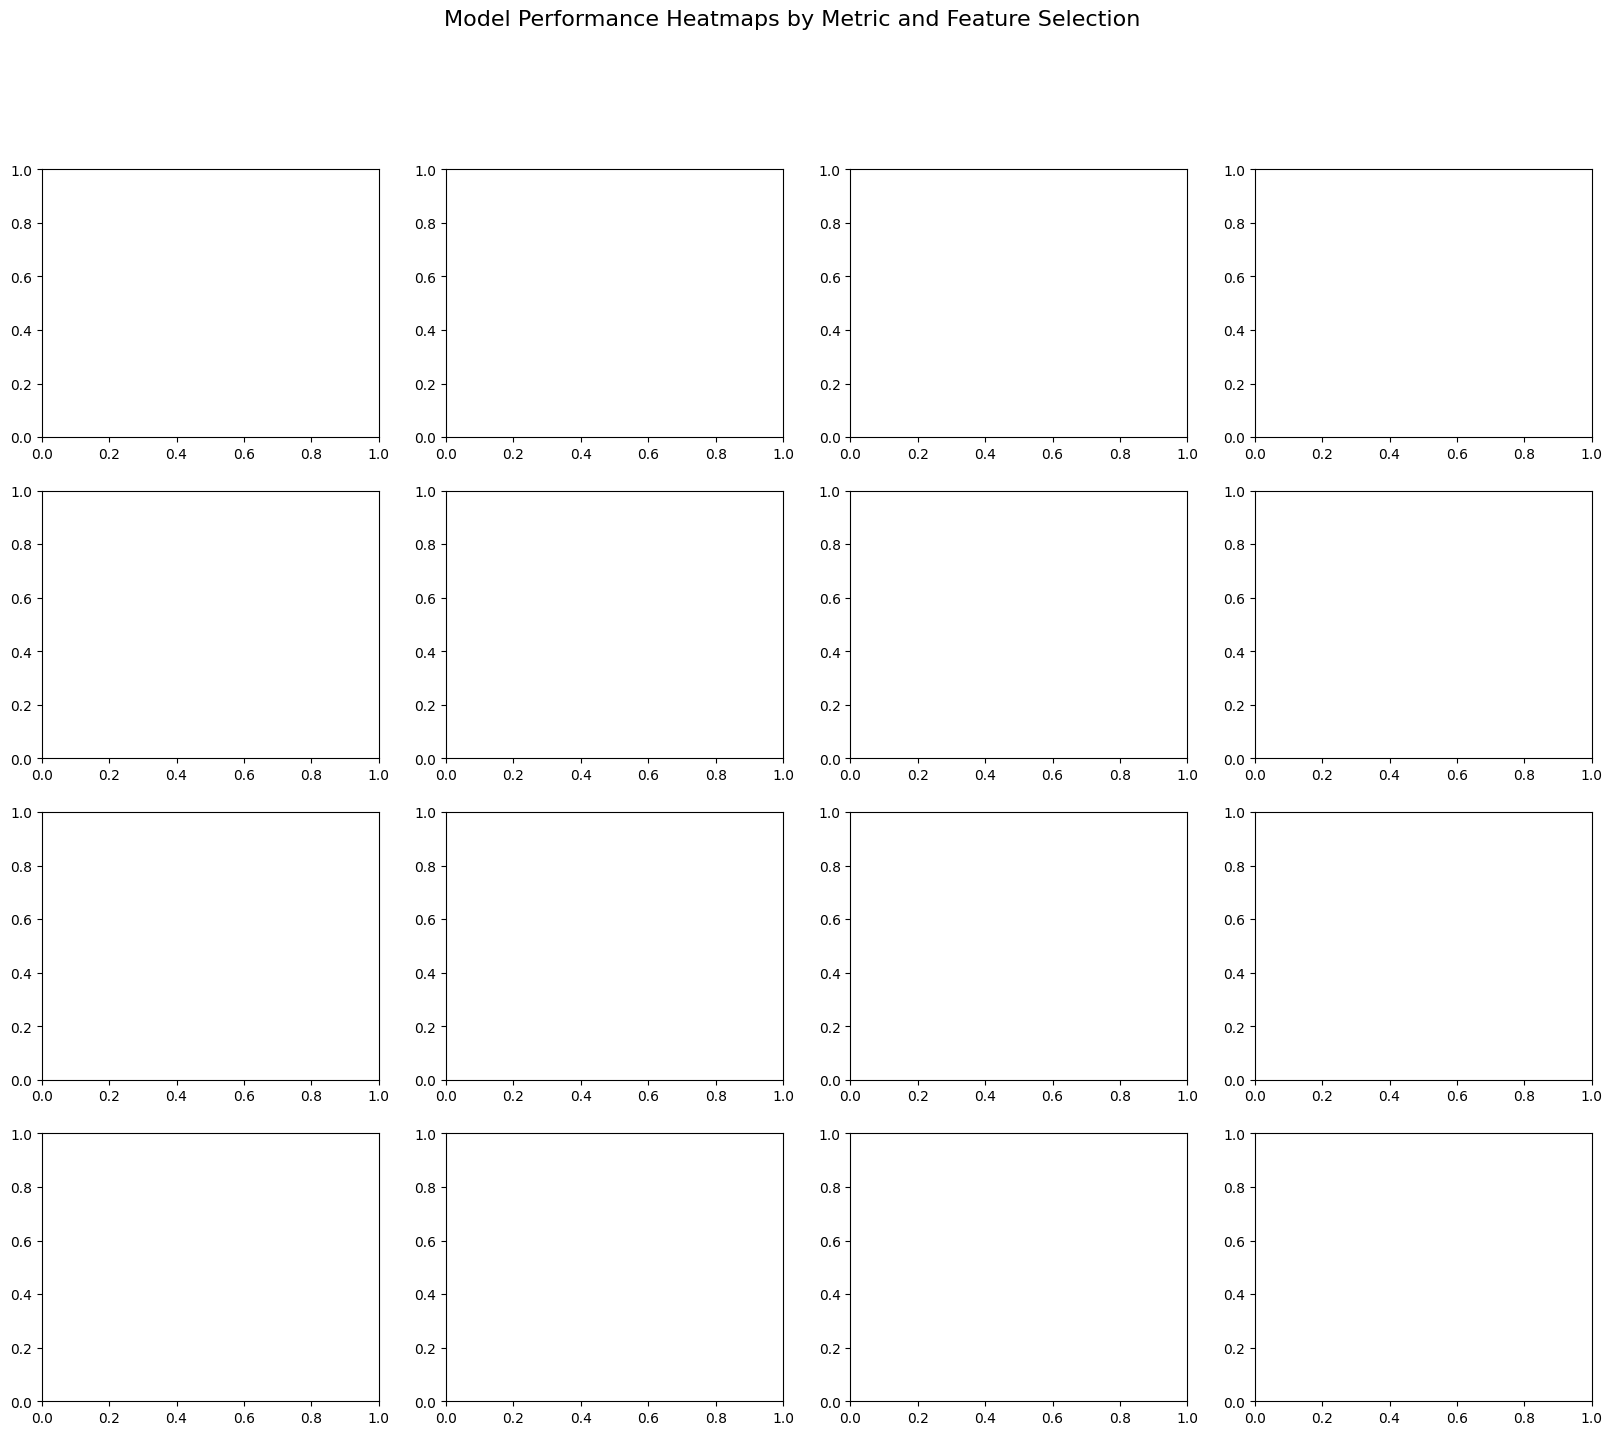

In [ ]:
# # Get unique values
# metrics = df_results_feature_selection['Metric'].unique()
# classifiers = df_results_feature_selection['Model'].unique()
# datasets = df_results_feature_selection['Dataset'].unique()
# split_ratios = df_results_feature_selection['FeatureSelection'].unique()

# # Create figure with subplots
# fig, axes = plt.subplots(len(metrics), len(split_ratios), 
#                          figsize=(5*len(split_ratios), 4*len(metrics)))
# fig.suptitle("Model Performance Heatmaps by Metric and Feature Selection", fontsize=16)

# # Flatten axes array if there's only one row
# if len(metrics) == 1:
#     axes = axes.reshape(1, -1)

# for i, metric in enumerate(metrics):
#     for j, ratio in enumerate(split_ratios):
#         data = df_results_feature_selection[(df_results_feature_selection['Metric'] == metric) & 
#                           (df_results_feature_selection['FeatureSelection'] == ratio)]
        
#         # Create pivot table for this subplot
#         pivot = data.pivot(index='Dataset', columns='Model', values='Score')
        
#         # Create heatmap
#         sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".3f", 
#                     ax=axes[i, j], cbar=False)
        
#         axes[i, j].set_title(f"{metric} - {ratio}")
        
#         # Remove x and y labels
#         axes[i, j].set_xlabel('')
#         axes[i, j].set_ylabel('')
        
#         # Rotate x-axis labels
#         axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), rotation=45, ha='right')

# # Remove any unused subplots
# for i in range(len(metrics)):
#     for j in range(len(split_ratios), axes.shape[1]):
#         fig.delaxes(axes[i, j])

# # Adjust layout
# plt.tight_layout()
# plt.subplots_adjust(top=0.95)

# # Show plot
# plt.show()

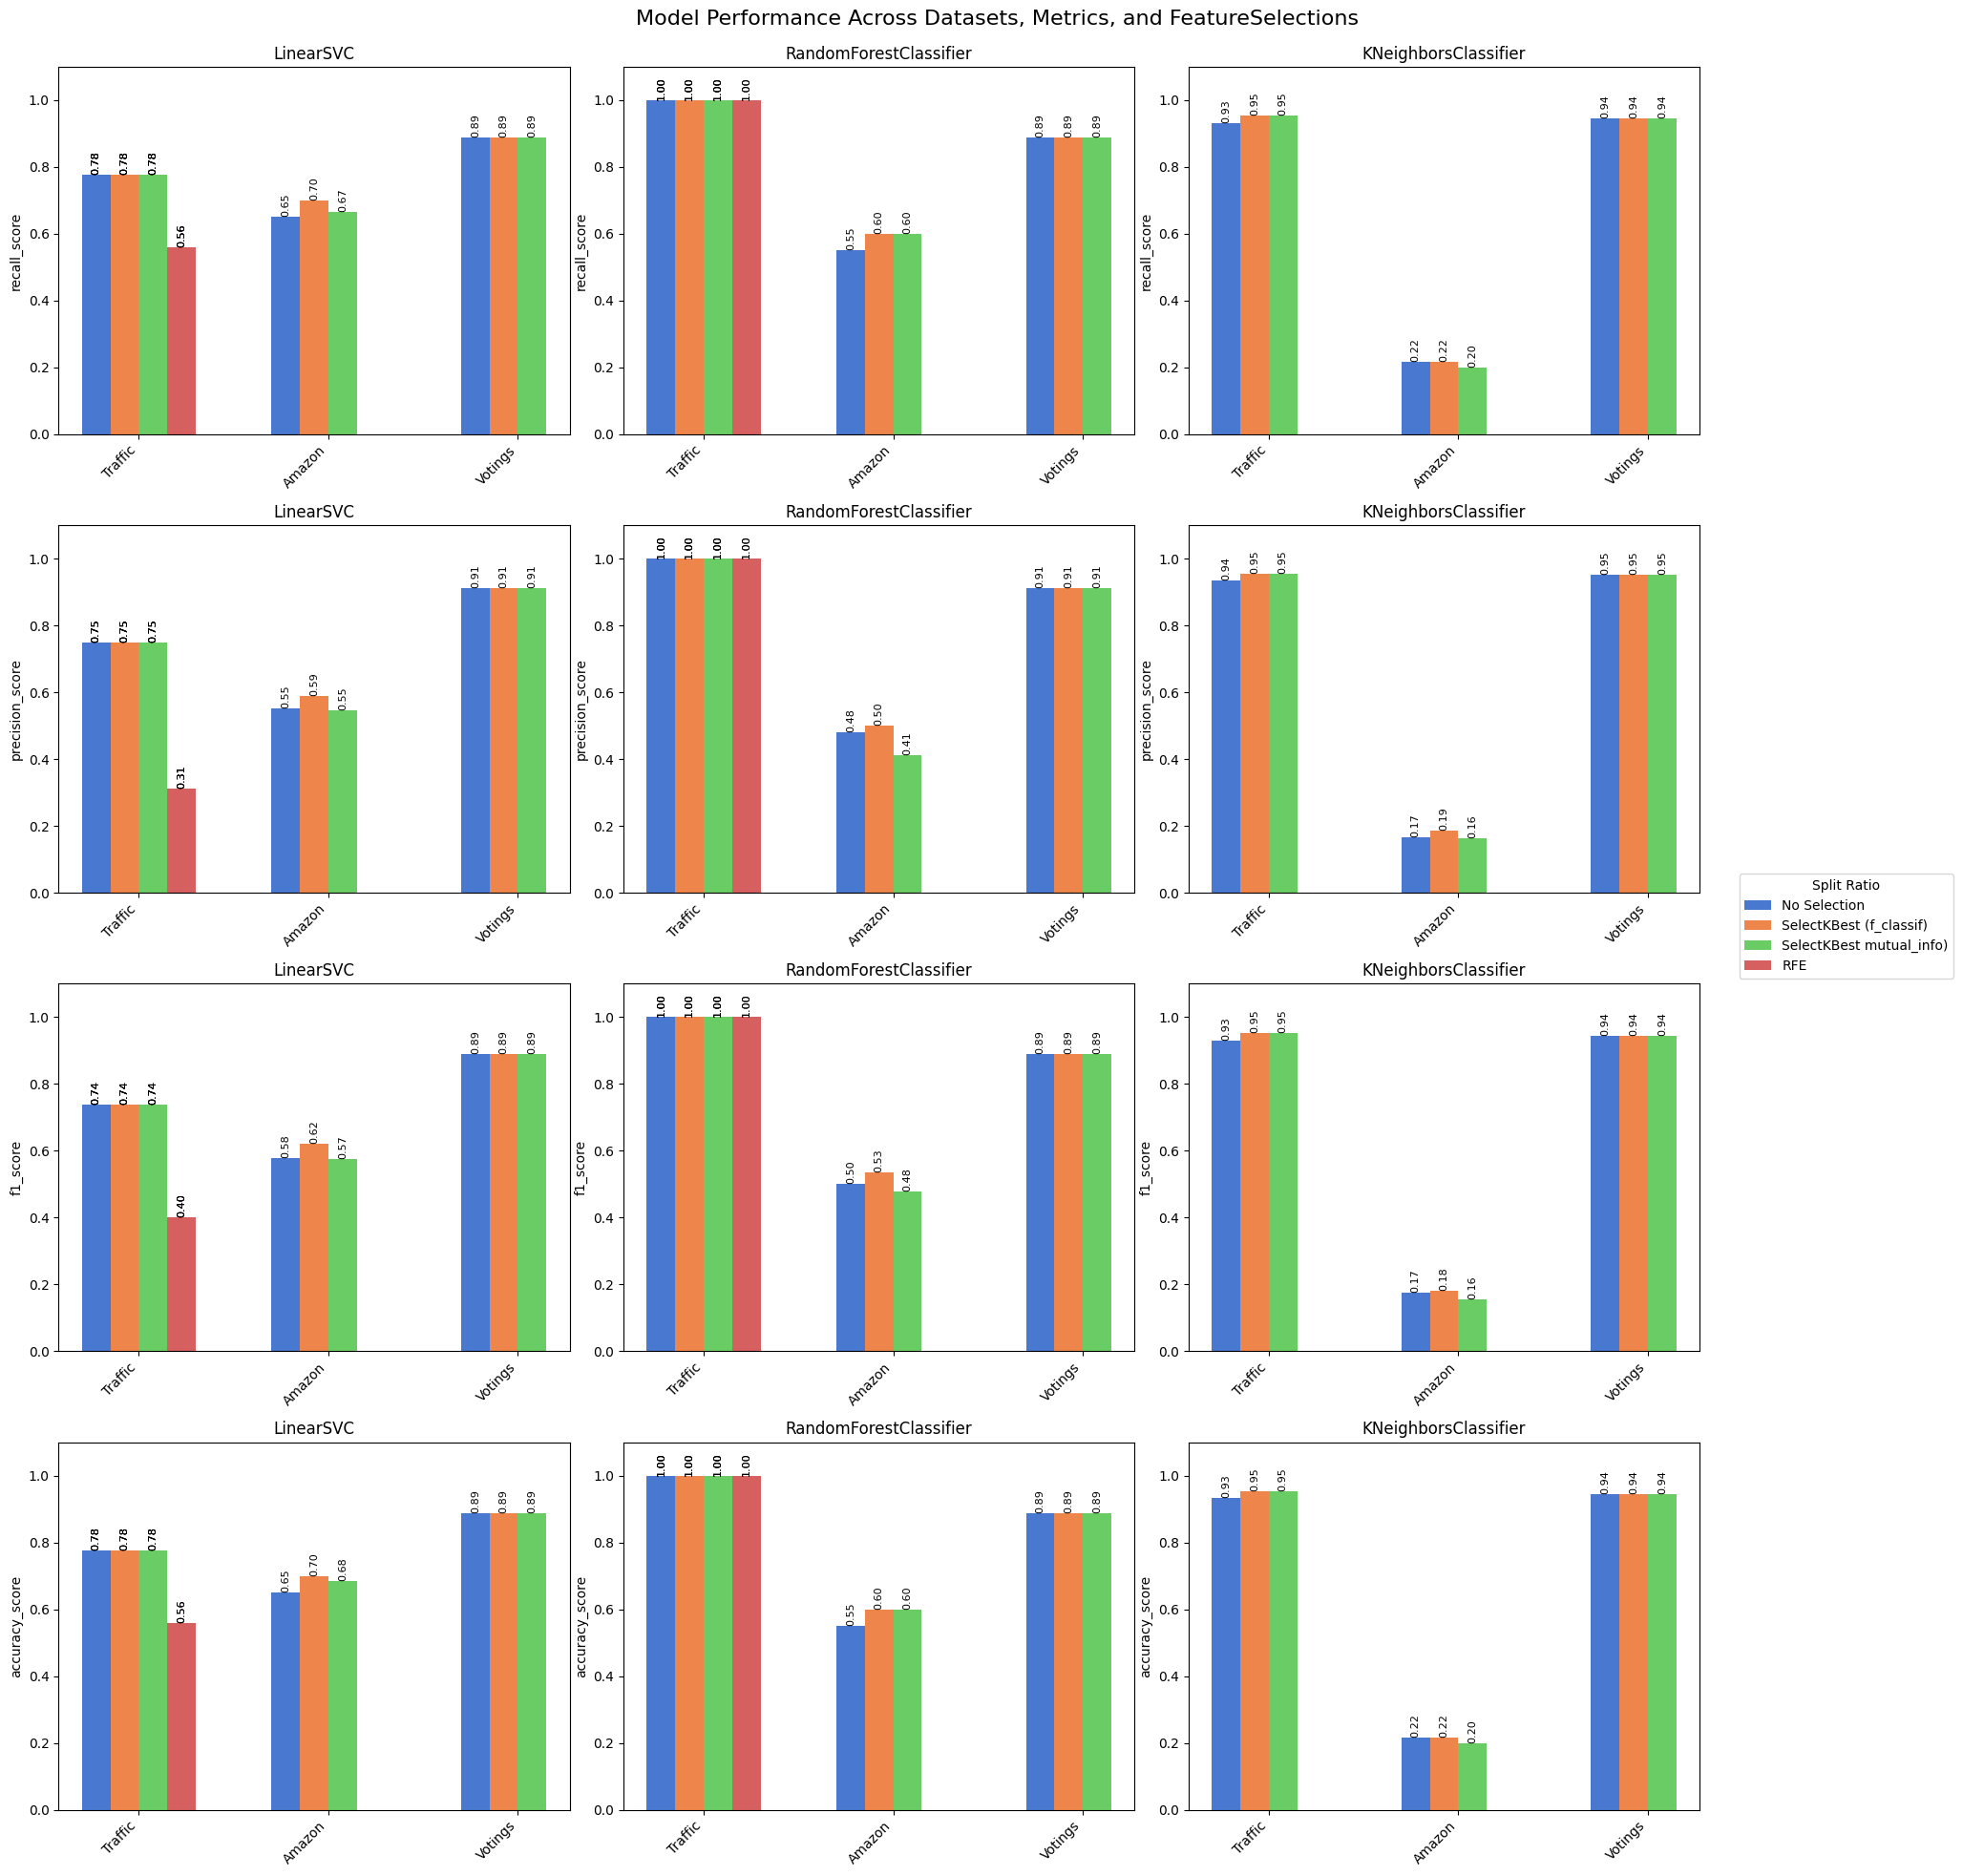

In [ ]:

# Define number of subplots per row
n_subplots_per_row = 3

metrics = df_results_feature_selection['Metric'].unique()
classifiers = df_results_feature_selection['Model'].unique()
datasets = df_results_feature_selection['Dataset'].unique()
split_ratios = df_results_feature_selection['FeatureSelection'].unique()

n_rows = len(metrics)

fig, axes = plt.subplots(n_rows, n_subplots_per_row, figsize=(7*n_subplots_per_row, 5*n_rows))
fig.suptitle("Model Performance Across Datasets, Metrics, and FeatureSelections", fontsize=16)

split_ratio_palette = sns.color_palette("muted", n_colors=len(split_ratios))
split_ratio_color_dict = dict(zip(split_ratios, split_ratio_palette))

for i, metric in enumerate(metrics):
    for j, classifier in enumerate(classifiers):
        ax = axes[i, j % n_subplots_per_row]
        data = df_results_feature_selection[(df_results_feature_selection['Metric'] == metric) & (df_results_feature_selection['Model'] == classifier)]

        bar_width = 0.15
        group_width = len(split_ratios) * bar_width
        x = np.arange(len(datasets))

        for k, dataset in enumerate(datasets):
            for m, split_ratio in enumerate(split_ratios):
                subset = data[(data['Dataset'] == dataset) & (data['FeatureSelection'] == split_ratio)]
                if not subset.empty:
                    bar_position = x[k] + (m - (len(split_ratios)-1)/2) * bar_width
                    bar = ax.bar(bar_position, subset['Score'], bar_width, 
                                 color=split_ratio_color_dict[split_ratio],
                                 label=split_ratio)
                    
                    for rect in bar:
                        height = rect.get_height()
                        ax.text(rect.get_x() + rect.get_width()/2., height,
                                f'{height:.2f}', ha='center', va='bottom', rotation=90, fontsize=8)

        ax.set_ylabel(f'{metric}')
        ax.set_title(f"{classifier}")
        ax.set_xticks(x)
        ax.set_xticklabels(datasets, rotation=45, ha='right')
        ax.set_ylim(0, 1.1)

# Remove any unused subplots
for i in range(n_rows):
    for j in range(len(classifiers), n_subplots_per_row):
        fig.delaxes(axes[i, j])

# Create a single legend for all plots without duplicates
handles, labels = axes[0, 0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), title='Split Ratio', loc='center right', bbox_to_anchor=(0.98, 0.5))

plt.tight_layout()
plt.subplots_adjust(right=0.85, top=0.95)
plt.show()

# 7. Try out different ML algorithms

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

def compare_methods(X_train: pd.DataFrame, X_valid: pd.DataFrame, 
                   y_train: pd.DataFrame, y_valid: pd.DataFrame) -> typing.Dict[str, float]:
    scores = {}
    metric = 'f1_weighted'  # or another metric
    
    # Define models and their parameter grids
    models = {
        'LinearSVC': {
            'model': LinearSVC(random_state=42),
            'params': {
                'C': [0.1, 1, 10],
                'dual': [True, False],
                'max_iter': [1000]
            }
        },
        'RandomForest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [10, 20],
                'max_depth': [5, 10, 15],
                'min_samples_split': [2, 5]
            }
        },
        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3, 5, 7, 9],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan', 'cityblock'],
                'algorithm':  ["ball_tree", "kd_tree", "brute"]
            }
        }
    }
    
    for name, config in models.items():
        print(f"\nEvaluating START {name}...")
        
        grid_search = GridSearchCV(
            estimator=config['model'],
            param_grid=config['params'],
            cv=10,  # 10-fold cross-validation
            scoring=metric,
            n_jobs=-1  # Use all available cores
        )
        
        # Fit the model
        grid_search.fit(X_train, y_train)
        
        # Get best model
        best_model = grid_search.best_estimator_
        
        # Cross-validation
        cv_scores = cross_val_score(
            best_model,
            X_train,
            y_train,
            cv=10,
            scoring=metric
        )
        
        # Validation score
        y_pred = best_model.predict(X_valid)
        valid_score = f1_score(y_valid, y_pred, average='weighted')
        
        # Store and print results
        scores[f"{name} (CV)"] = np.mean(cv_scores)
        scores[f"{name} (Valid)"] = valid_score
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Cross-validation score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
        print(f"Validation score: {valid_score:.4f}")
    
    return scores

In [ ]:
results = []
for dataset_name, dataset in train_valid_data.items():
    print(f"==============\n{dataset_name}-Dataset")
    #for scaler_name, scaler_class in suitable_scalings.items():
    diff_methods_scores = compare_methods(dataset.X_train, dataset.X_valid, dataset.y_train, dataset.y_valid)

Traffic-Dataset

Evaluating START LinearSVC...


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: Converg

Best parameters: {'C': 10, 'dual': False, 'max_iter': 1000}
Cross-validation score: 0.7856 ± 0.0198
Validation score: 0.7439

Evaluating START RandomForest...
Best parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 20}
Cross-validation score: 0.9883 ± 0.0087
Validation score: 1.0000

Evaluating START KNN...
Best parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Cross-validation score: 0.9348 ± 0.0173
Validation score: 0.9438

Evaluating START LinearSVC...


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: Converg

Best parameters: {'C': 10, 'dual': False, 'max_iter': 1000}
Cross-validation score: 0.7856 ± 0.0198
Validation score: 0.7439

Evaluating START RandomForest...
Best parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 20}
Cross-validation score: 0.9883 ± 0.0087
Validation score: 1.0000

Evaluating START KNN...
Best parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Cross-validation score: 0.9348 ± 0.0173
Validation score: 0.9438

Evaluating START LinearSVC...


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: Converg

Best parameters: {'C': 10, 'dual': False, 'max_iter': 1000}
Cross-validation score: 0.7856 ± 0.0198
Validation score: 0.7439

Evaluating START RandomForest...
Best parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 20}
Cross-validation score: 0.9883 ± 0.0087
Validation score: 1.0000

Evaluating START KNN...
Best parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Cross-validation score: 0.9348 ± 0.0173
Validation score: 0.9438

Evaluating START LinearSVC...


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: Converg

Best parameters: {'C': 10, 'dual': False, 'max_iter': 1000}
Cross-validation score: 0.7856 ± 0.0198
Validation score: 0.7439

Evaluating START RandomForest...
Best parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 20}
Cross-validation score: 0.9883 ± 0.0087
Validation score: 1.0000

Evaluating START KNN...
Best parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Cross-validation score: 0.9348 ± 0.0173
Validation score: 0.9438
Amazon-Dataset

Evaluating START LinearSVC...


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm

Best parameters: {'C': 0.1, 'dual': True, 'max_iter': 1000}
Cross-validation score: 0.5363 ± 0.0983
Validation score: 0.5794

Evaluating START RandomForest...


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Best parameters: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 20}
Cross-validation score: 0.3161 ± 0.0396
Validation score: 0.2489

Evaluating START KNN...


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Best parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Cross-validation score: 0.3325 ± 0.0536
Validation score: 0.3189

Evaluating START LinearSVC...


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm

Best parameters: {'C': 0.1, 'dual': True, 'max_iter': 1000}
Cross-validation score: 0.5363 ± 0.0983
Validation score: 0.5794

Evaluating START RandomForest...


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Best parameters: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 20}
Cross-validation score: 0.3161 ± 0.0396
Validation score: 0.2489

Evaluating START KNN...


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Best parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Cross-validation score: 0.3325 ± 0.0536
Validation score: 0.3189

Evaluating START LinearSVC...


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm

Best parameters: {'C': 0.1, 'dual': True, 'max_iter': 1000}
Cross-validation score: 0.5363 ± 0.0983
Validation score: 0.5794

Evaluating START RandomForest...


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Best parameters: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 20}
Cross-validation score: 0.3161 ± 0.0396
Validation score: 0.2489

Evaluating START KNN...


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Best parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Cross-validation score: 0.3325 ± 0.0536
Validation score: 0.3189

Evaluating START LinearSVC...


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm

Best parameters: {'C': 0.1, 'dual': True, 'max_iter': 1000}
Cross-validation score: 0.5363 ± 0.0983
Validation score: 0.5794

Evaluating START RandomForest...


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Best parameters: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 20}
Cross-validation score: 0.3161 ± 0.0396
Validation score: 0.2489

Evaluating START KNN...


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Best parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Cross-validation score: 0.3325 ± 0.0536
Validation score: 0.3189
Votings-Dataset

Evaluating START LinearSVC...
Best parameters: {'C': 0.1, 'dual': True, 'max_iter': 1000}
Cross-validation score: 0.9621 ± 0.0500
Validation score: 0.8889

Evaluating START RandomForest...


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}
Cross-validation score: 0.9682 ± 0.0424
Validation score: 0.8889

Evaluating START KNN...
Best parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Cross-validation score: 0.9560 ± 0.0487
Validation score: 0.9446

Evaluating START LinearSVC...


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters: {'C': 0.1, 'dual': True, 'max_iter': 1000}
Cross-validation score: 0.9621 ± 0.0500
Validation score: 0.8889

Evaluating START RandomForest...
Best parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}
Cross-validation score: 0.9682 ± 0.0424
Validation score: 0.8889

Evaluating START KNN...
Best parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Cross-validation score: 0.9560 ± 0.0487
Validation score: 0.9446

Evaluating START LinearSVC...


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters: {'C': 0.1, 'dual': True, 'max_iter': 1000}
Cross-validation score: 0.9621 ± 0.0500
Validation score: 0.8889

Evaluating START RandomForest...
Best parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}
Cross-validation score: 0.9682 ± 0.0424
Validation score: 0.8889

Evaluating START KNN...
Best parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Cross-validation score: 0.9560 ± 0.0487
Validation score: 0.9446

Evaluating START LinearSVC...
Best parameters: {'C': 0.1, 'dual': True, 'max_iter': 1000}
Cross-validation score: 0.9621 ± 0.0500
Validation score: 0.8889

Evaluating START RandomForest...


/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/pw98/repos/uni/01/machine-learning/ds-ml-project/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}
Cross-validation score: 0.9682 ± 0.0424
Validation score: 0.8889

Evaluating START KNN...
Best parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Cross-validation score: 0.9560 ± 0.0487
Validation score: 0.9446


# 8. Explore the effect of parameters

In [ ]:
def compare_param_effect(df:pd.DataFrame, base_params, param_variations) -> typing.Dict[str, float]:
    scores = {}
    
    # Separate features and target
    X = df.drop('class', axis=1)
    y = df['class']
    
    # # Base model (RandomForestClassifier)
    # base_params = {
    #     'n_estimators': 100,
    #     'max_depth': None,
    #     'min_samples_split': 2,
    #     'random_state': 42
    # }
    
    # # Parameter variations to explore
    # param_variations = {
    #     'n_estimators': [25, 50, 75],
    #     'max_depth': [10, 20, None],
    #     'min_samples_split': [2, 5, 10]
    # }
    
    # Explore each parameter while keeping others at base values
    for param_name, param_values in param_variations.items():
        print(f"\nExploring {param_name}...")
        
        for value in param_values:
            # Create parameter dictionary
            current_params = base_params.copy()
            current_params[param_name] = value
            
            # Create and train model
            model = RandomForestClassifier(**current_params)
            
            # Perform 10-fold cross-validation
            cv_scores = cross_val_score(
                model,
                X,
                y,
                cv=10,
                scoring='f1_weighted',
                n_jobs=-1
            )
            
            # Store mean and std of scores
            param_setting = f"{param_name}={value}"
            scores[param_setting] = {
                'mean': cv_scores.mean(),
                'std': cv_scores.std()
            }
            
            print(f"{param_setting}: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    return scores

In [ ]:
param_effect_scores = compare_param_effect(data_train)

print_scores(param_effect_scores)

# 9. Present your best performing results

In [ ]:
# todo pw